# Bayesian Deep Learning

Conventional neural networks are not well designed to model the uncertainty associated with the predictions they make. For that, one way is to go full Bayesian. 

In this class we will introduce the concept of Bayesian Neural Networks (BNN) by studing a standard supervised use case: a toy regression problem. For that, we will first implement linear regression and learn point estimates for the parameters w and b. Then we’ll see how to incorporate uncertainty into our estimates by using MCMC to implement Bayesian linear regression.


# Main definitions

A Bayesian neural network is a neural network with a prior distribution on its weights. This means that, in contrast with any convential (non-Bayesian) neural network, BNNs are interested not only in the optimal values of the network's parameters -- weights and biases -- but also in the distribution associated with them. Thanks to these distributions we could have a certain level of confidence about the network predictions.

The  idea  behind  Bayesian  neural  networks is then to cast the task of training a network as a problem of inference, which is solved using Bayes’ theorem. The latter theorem is used to assign a probability density to each point in the parameter space of the neural network, as it is featured below. 


### Bayes Formula

Estimating the distributions associated with the network parameters is hard. These are generally referred to as posterior densities, and are estimated using the Bayes rule.

$$p \left(w \mid x,y \right) = \frac{p \left( x,y \mid w \right) p(w)}{\int p \left( x, y \mid w\right) p(w)dw}$$

The main problem lies in the denominator — also known as model evidence. It requires integrating over all possible values of the parameters (i.e., all weights and biases space), and it is often not doable in practice.

Instead, pseudo-numerical approaches can be chosen where the solution to those integrals is approximated. The most common approaches are: 

1.- Approximating the integral with MCMC

2.- Using variational inference 

3.-Using MC dropout



In this notebook we will explore the MCMC approach with the help of the tensorflow_probability library

## Bayesian Regression

But first, let's dive deep into the basic principles with the regression example.

Regression is one of the most common and basic supervised learning tasks in machine learning.

Considering $\mathcal{D} = \left( \boldsymbol{X},\boldsymbol{Y} \right) = \left\{ (\boldsymbol{x}_i,y_i) \right\}_{i=1}^{N}$. Suppose there exist $f(x)$ so that 

$$y = f(x)$$

We want to find $f(x) = \phi_w (x)$ where $w$ are the parameters of the later function.

Let’s first implement linear regression and learn point estimates for the parameters w and b. Then we’ll see how to incorporate uncertainty into our estimates to implement Bayesian linear regression.

But, first of all, let’s import the modules we’ll need!

In [1]:
#Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout
from keras.layers import Input
from keras import backend as K
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.engine.topology import Layer
import tensorflow as tf

import tensorflow as tf
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

K.set_session(sess)

Using TensorFlow backend.


Generate a toy dataset of 100 data points with one feature and w=3.5 and b=-9.3:

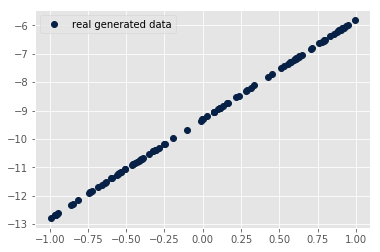

In [2]:
points = 100  # number of data points
low = -1.
high = 1.
X_train = np.random.uniform(low=low,high=high,size=(points))

def f(x):
    a_0 = -9.3
    a_1 = 3.5
    return a_0+x*a_1

y_train = f(X_train)

plt.plot(X_train,y_train,'o',
         c='#072146',label='real generated data')
plt.legend()
plt.show()

Now add some constant noise in the predicted dimension:

$$y = f(x) + \epsilon$$

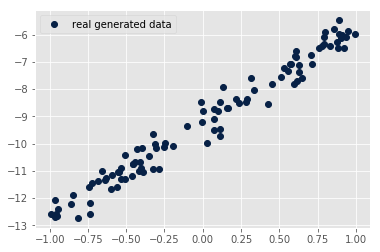

In [3]:
std = 0.4
epsilon = np.random.normal(0,std,size=(points))

y_train = f(X_train)+epsilon

plt.plot(X_train,y_train,'o',
         c='#072146',label='real generated data')
plt.legend()
plt.show()

Thus, the problem state as $$y = \phi_w (x) + \epsilon$$

$$ p(y \mid x, w, \epsilon) = \mathcal{N}(y \mid \phi_w(x), \epsilon^2)$$

where $\phi_w (x) = w_1 x + w_2$



$$ p(y_{i}\mid x_{i},w, \epsilon)=\frac{1}{\sqrt{2\pi\epsilon^{2}}}\exp\left(-\frac{\left(y_{i}-\phi_{w}(x_{i})\right)^{2}}{2\epsilon^{2}}\right)$$

$$\Rightarrow-\ln\left(p(y_{i}\mid x_{i},w)\right)\Big|_{\{w,\epsilon\}}=-\ln(\epsilon)-\frac{\left(y_{i}-\phi_{w}(x_{i})\right)^{2}}{2\epsilon^{2}}$$

Define using keras (K) the second term of the above formula:

In [4]:
def log_normal_pdf(y, output_psi, epsilon):
    return -K.log(epsilon)-(K.square(y-output_psi)/(2.*K.square(epsilon)))

Particularize the above function with the real y and the parameters' values:

In [5]:
def regression(y_true, parameters):
    mu = parameters[:,:-1]
    sigma = parameters[:,-1:]
    return -K.sum(log_normal_pdf(y_true[:,:1],
                                 mu,sigma))

Custom keras' layer to deal with scalars:

In [6]:
class Scalar(Layer):
    def __init__(self, units = 1, initializer=K.zeros, 
                 activation = None, **kwargs):
        super(Scalar, self).__init__(**kwargs)
        self.scalar_initializer = initializer
        self.units = units
        self.activation = activation
        
    def build(self, bs_input):
        self.scalar = self.add_weight("sigma_hom", 
                                      shape=[self.units],  
                                      initializer=self.scalar_initializer)
        self.params = [self.scalar]
    
    def get_output(self, train=False):
        output = self.scalar*K.ones_like(self.get_input()[:,:1])
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def call(self, bs_input):
        output = self.scalar*K.ones_like(bs_input[:,:1])
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

Build a function which retuns the ELU value of x + 1 given x:

In [7]:
from keras.layers import ELU

def elu_plus1(x, a=1.):
    return ELU(alpha=a)(x)+1.

Train the regression model:

In [8]:
i = Input(name='input', shape=(1,), dtype='float32')

phi = Dense(units=1, activation="linear", name='w',
              kernel_initializer='ones')(i)

epsilon = Scalar(activation=elu_plus1)(i)

model = Model(
    inputs=[i],
    outputs=[concatenate([phi,epsilon],  
                         axis=1, 
                         name='main_output')])

opt = Adam(lr=0.1)
model.compile(optimizer=opt, loss={'main_output':regression})

In [9]:
history = model.fit(X_train.reshape(-1,1), 
          np.repeat(y_train.reshape(-1,1),2,axis=1), 
          epochs=1000, validation_split=0.1,verbose=1)

Train on 90 samples, validate on 10 samples
Epoch 1/1000
90/90 [==============================] - 1s 8ms/step - loss: 1119.7524 - val_loss: 233.2484
Epoch 2/1000
90/90 [==============================] - 0s 101us/step - loss: 664.4039 - val_loss: 153.7306
Epoch 3/1000
90/90 [==============================] - 0s 93us/step - loss: 446.5157 - val_loss: 112.6658
Epoch 4/1000
90/90 [==============================] - 0s 122us/step - loss: 337.6080 - val_loss: 88.6804
Epoch 5/1000
90/90 [==============================] - 0s 94us/step - loss: 269.2354 - val_loss: 73.5421
Epoch 6/1000
90/90 [==============================] - 0s 95us/step - loss: 225.5292 - val_loss: 63.3354
Epoch 7/1000
90/90 [==============================] - 0s 84us/step - loss: 195.0624 - val_loss: 56.1400
Epoch 8/1000
90/90 [==============================] - 0s 146us/step - loss: 174.2650 - val_loss: 50.8321
Epoch 9/1000
90/90 [==============================] - 0s 117us/step - loss: 158.6245 - val_loss: 46.7819
Epoch 10/1000

90/90 [==============================] - 0s 91us/step - loss: 42.6929 - val_loss: 13.5977
Epoch 80/1000
90/90 [==============================] - 0s 101us/step - loss: 42.3952 - val_loss: 13.5074
Epoch 81/1000
90/90 [==============================] - 0s 97us/step - loss: 42.0564 - val_loss: 13.4195
Epoch 82/1000
90/90 [==============================] - 0s 97us/step - loss: 41.7841 - val_loss: 13.3334
Epoch 83/1000
90/90 [==============================] - 0s 103us/step - loss: 41.5385 - val_loss: 13.2493
Epoch 84/1000
90/90 [==============================] - 0s 105us/step - loss: 41.2546 - val_loss: 13.1669
Epoch 85/1000
90/90 [==============================] - 0s 113us/step - loss: 40.9440 - val_loss: 13.0860
Epoch 86/1000
90/90 [==============================] - 0s 101us/step - loss: 40.7240 - val_loss: 13.0067
Epoch 87/1000
90/90 [==============================] - 0s 115us/step - loss: 40.4056 - val_loss: 12.9288
Epoch 88/1000
90/90 [==============================] - 0s 92us/step - lo

90/90 [==============================] - 0s 99us/step - loss: -14.4583 - val_loss: -4.8504
Epoch 236/1000
90/90 [==============================] - 0s 94us/step - loss: -14.6853 - val_loss: -4.7229
Epoch 237/1000
90/90 [==============================] - 0s 100us/step - loss: -14.7711 - val_loss: -4.5344
Epoch 238/1000
90/90 [==============================] - 0s 84us/step - loss: -14.9683 - val_loss: -4.3012
Epoch 239/1000
90/90 [==============================] - 0s 103us/step - loss: -14.8410 - val_loss: -4.2017
Epoch 240/1000
90/90 [==============================] - 0s 108us/step - loss: -14.3043 - val_loss: -4.5108
Epoch 241/1000
90/90 [==============================] - 0s 94us/step - loss: -14.8253 - val_loss: -5.0215
Epoch 242/1000
90/90 [==============================] - 0s 114us/step - loss: -14.2877 - val_loss: -4.4627
Epoch 243/1000
90/90 [==============================] - 0s 93us/step - loss: -14.6319 - val_loss: -4.8449
Epoch 244/1000
90/90 [==============================] - 0

90/90 [==============================] - 0s 90us/step - loss: -14.4381 - val_loss: -3.5885
Epoch 390/1000
90/90 [==============================] - 0s 114us/step - loss: -14.6412 - val_loss: -3.9676
Epoch 391/1000
90/90 [==============================] - 0s 92us/step - loss: -14.3959 - val_loss: -5.1850
Epoch 392/1000
90/90 [==============================] - 0s 108us/step - loss: -14.3409 - val_loss: -5.2940
Epoch 393/1000
90/90 [==============================] - 0s 107us/step - loss: -14.8311 - val_loss: -4.6209
Epoch 394/1000
90/90 [==============================] - 0s 88us/step - loss: -14.4731 - val_loss: -3.6848
Epoch 395/1000
90/90 [==============================] - 0s 97us/step - loss: -14.2352 - val_loss: -4.0483
Epoch 396/1000
90/90 [==============================] - 0s 94us/step - loss: -14.7800 - val_loss: -4.6872
Epoch 397/1000
90/90 [==============================] - 0s 102us/step - loss: -14.7717 - val_loss: -4.9768
Epoch 398/1000
90/90 [==============================] - 0

Epoch 543/1000
90/90 [==============================] - 0s 102us/step - loss: -14.8858 - val_loss: -4.7523
Epoch 544/1000
90/90 [==============================] - 0s 85us/step - loss: -14.7698 - val_loss: -5.0329
Epoch 545/1000
90/90 [==============================] - 0s 95us/step - loss: -14.4057 - val_loss: -4.8678
Epoch 546/1000
90/90 [==============================] - 0s 114us/step - loss: -14.3857 - val_loss: -4.2367
Epoch 547/1000
90/90 [==============================] - 0s 95us/step - loss: -14.2497 - val_loss: -3.7331
Epoch 548/1000
90/90 [==============================] - 0s 110us/step - loss: -14.5965 - val_loss: -4.4763
Epoch 549/1000
90/90 [==============================] - 0s 94us/step - loss: -14.7873 - val_loss: -4.9687
Epoch 550/1000
90/90 [==============================] - 0s 110us/step - loss: -14.5532 - val_loss: -4.8198
Epoch 551/1000
90/90 [==============================] - 0s 111us/step - loss: -14.8207 - val_loss: -4.2927
Epoch 552/1000
90/90 [===================

Epoch 620/1000
90/90 [==============================] - 0s 92us/step - loss: -14.7023 - val_loss: -4.6706
Epoch 621/1000
90/90 [==============================] - 0s 137us/step - loss: -14.8595 - val_loss: -4.8994
Epoch 622/1000
90/90 [==============================] - 0s 98us/step - loss: -14.5136 - val_loss: -4.6410
Epoch 623/1000
90/90 [==============================] - 0s 95us/step - loss: -14.7485 - val_loss: -4.5119
Epoch 624/1000
90/90 [==============================] - 0s 119us/step - loss: -14.9004 - val_loss: -4.2704
Epoch 625/1000
90/90 [==============================] - 0s 113us/step - loss: -14.4703 - val_loss: -4.4712
Epoch 626/1000
90/90 [==============================] - 0s 98us/step - loss: -14.7822 - val_loss: -4.4874
Epoch 627/1000
90/90 [==============================] - 0s 122us/step - loss: -14.5028 - val_loss: -4.7082
Epoch 628/1000
90/90 [==============================] - 0s 98us/step - loss: -14.7456 - val_loss: -4.6826
Epoch 629/1000
90/90 [====================

90/90 [==============================] - 0s 95us/step - loss: -14.3082 - val_loss: -4.7580
Epoch 698/1000
90/90 [==============================] - 0s 116us/step - loss: -14.8982 - val_loss: -4.8551
Epoch 699/1000
90/90 [==============================] - 0s 97us/step - loss: -14.9287 - val_loss: -4.4640
Epoch 700/1000
90/90 [==============================] - 0s 78us/step - loss: -14.5826 - val_loss: -3.9457
Epoch 701/1000
90/90 [==============================] - 0s 94us/step - loss: -14.5931 - val_loss: -4.3159
Epoch 702/1000
90/90 [==============================] - 0s 93us/step - loss: -14.7279 - val_loss: -4.5794
Epoch 703/1000
90/90 [==============================] - 0s 101us/step - loss: -14.3513 - val_loss: -5.2376
Epoch 704/1000
90/90 [==============================] - 0s 122us/step - loss: -14.3046 - val_loss: -4.9191
Epoch 705/1000
90/90 [==============================] - 0s 87us/step - loss: -14.6632 - val_loss: -3.8530
Epoch 706/1000
90/90 [==============================] - 0s

90/90 [==============================] - 0s 91us/step - loss: -14.7605 - val_loss: -4.5340
Epoch 775/1000
90/90 [==============================] - 0s 114us/step - loss: -14.6883 - val_loss: -4.4297
Epoch 776/1000
90/90 [==============================] - 0s 94us/step - loss: -15.0116 - val_loss: -4.6519
Epoch 777/1000
90/90 [==============================] - 0s 95us/step - loss: -14.5098 - val_loss: -4.4976
Epoch 778/1000
90/90 [==============================] - 0s 91us/step - loss: -14.6453 - val_loss: -4.2144
Epoch 779/1000
90/90 [==============================] - 0s 94us/step - loss: -14.9205 - val_loss: -5.0027
Epoch 780/1000
90/90 [==============================] - 0s 102us/step - loss: -14.7000 - val_loss: -4.8132
Epoch 781/1000
90/90 [==============================] - 0s 101us/step - loss: -14.2838 - val_loss: -4.3997
Epoch 782/1000
90/90 [==============================] - 0s 92us/step - loss: -14.5386 - val_loss: -3.9919
Epoch 783/1000
90/90 [==============================] - 0s

90/90 [==============================] - 0s 119us/step - loss: -14.5698 - val_loss: -4.6578
Epoch 852/1000
90/90 [==============================] - 0s 133us/step - loss: -14.9846 - val_loss: -4.4179
Epoch 853/1000
90/90 [==============================] - 0s 128us/step - loss: -14.8810 - val_loss: -4.6835
Epoch 854/1000
90/90 [==============================] - 0s 114us/step - loss: -14.8813 - val_loss: -4.9604
Epoch 855/1000
90/90 [==============================] - 0s 127us/step - loss: -14.5216 - val_loss: -4.3850
Epoch 856/1000
90/90 [==============================] - 0s 104us/step - loss: -14.9512 - val_loss: -4.3371
Epoch 857/1000
90/90 [==============================] - 0s 101us/step - loss: -14.9243 - val_loss: -4.4623
Epoch 858/1000
90/90 [==============================] - 0s 143us/step - loss: -14.7426 - val_loss: -4.4949
Epoch 859/1000
90/90 [==============================] - 0s 154us/step - loss: -14.7098 - val_loss: -4.7137
Epoch 860/1000
90/90 [==============================

Epoch 928/1000
90/90 [==============================] - 0s 92us/step - loss: -14.9698 - val_loss: -4.6208
Epoch 929/1000
90/90 [==============================] - 0s 114us/step - loss: -14.8779 - val_loss: -4.0477
Epoch 930/1000
90/90 [==============================] - 0s 94us/step - loss: -14.6201 - val_loss: -4.2029
Epoch 931/1000
90/90 [==============================] - 0s 108us/step - loss: -14.5477 - val_loss: -4.4958
Epoch 932/1000
90/90 [==============================] - 0s 92us/step - loss: -14.9262 - val_loss: -4.9145
Epoch 933/1000
90/90 [==============================] - 0s 96us/step - loss: -14.2741 - val_loss: -5.0581
Epoch 934/1000
90/90 [==============================] - 0s 83us/step - loss: -15.1474 - val_loss: -4.7007
Epoch 935/1000
90/90 [==============================] - 0s 99us/step - loss: -14.3316 - val_loss: -3.6775
Epoch 936/1000
90/90 [==============================] - 0s 90us/step - loss: -14.9634 - val_loss: -4.0623
Epoch 937/1000
90/90 [======================

Make the predictions and visualize the results:

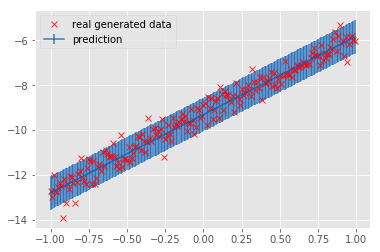

In [10]:
X_test = np.arange(low,high,0.01).reshape(-1,1)
y_test = f(X_test) + np.random.normal(
    0,std,size=(X_test.shape[0])).reshape(-1,1)

prediction = model.predict(X_test)

plt.errorbar(X_test,prediction[:,0],
             yerr=2*prediction[:,1],
             color='#0A5FB4',
             alpha=0.8,
             label='prediction')

plt.plot(X_test, y_test,'x',c='r',
         alpha=0.8, label='real generated data')

plt.legend()

plt.show()

## Variable noise

Let's now assume that our noise is not constant but a function of x:

$$y = f(x) + \epsilon(x)$$

As before, generate the data according to this new condition:

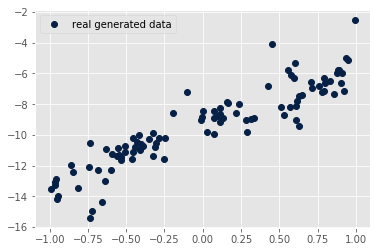

In [11]:
std = 0.4
epsilon = np.random.normal(0,std,size=(points))

y_train = f(X_train)+epsilon+[np.random.normal(0,i) for i in (np.sin(X_train*-10))+1]

plt.plot(X_train,y_train,'o',
         c='#072146',label='real generated data')
plt.legend()
plt.show()

Now, we have $$y = \phi_w (x) + \psi_v (x)$$

$$ p(y \mid x, w, v) = \mathcal{N}(y \mid \phi_w(x), \psi_v^2(x))=$$
            $$= \frac{1}{\sqrt{2\pi \psi_v(x)^2}} e^{-\frac{(y-\phi_w (x))^2}{2\psi_v(x)^2}}$$

i.e. We estimate a variability of $y_i$ for every data point $x_i$ 

Train the new regression model:

In [12]:
i = Input(name='input', shape=(1,), dtype='float32')

phi = Dense(units=1, activation="linear", 
            name='w',
            kernel_initializer='ones')(i)

psi = Dense(units=12, activation="sigmoid", 
            name='v_0')(i)
psi = Dense(units=6, activation="sigmoid", 
            name='v_1')(psi)
psi = Dense(units=1, activation=elu_plus1, 
            name='v_2')(psi)

model = Model(
    inputs=[i],
    outputs=[concatenate([phi,psi],  
                         axis=1, 
                         name='main_output')])

opt = Adam(lr=0.01)
model.compile(optimizer=opt, loss={'main_output':regression})

In [13]:
history = model.fit(X_train.reshape(-1,1), 
          np.repeat(y_train.reshape(-1,1),2,axis=1), 
          epochs=10000, validation_split=0.1,verbose=1)

Train on 90 samples, validate on 10 samples
Epoch 1/10000
90/90 [==============================] - 1s 11ms/step - loss: 448.4223 - val_loss: 123.2976
Epoch 2/10000
90/90 [==============================] - 0s 92us/step - loss: 357.7233 - val_loss: 101.4331
Epoch 3/10000
90/90 [==============================] - 0s 113us/step - loss: 296.0807 - val_loss: 86.4069
Epoch 4/10000
90/90 [==============================] - 0s 107us/step - loss: 254.0238 - val_loss: 75.8507
Epoch 5/10000
90/90 [==============================] - 0s 116us/step - loss: 225.7362 - val_loss: 68.1678
Epoch 6/10000
90/90 [==============================] - 0s 98us/step - loss: 202.3294 - val_loss: 62.4457
Epoch 7/10000
90/90 [==============================] - 0s 108us/step - loss: 187.5131 - val_loss: 58.0441
Epoch 8/10000
90/90 [==============================] - 0s 116us/step - loss: 174.4111 - val_loss: 54.6092
Epoch 9/10000
90/90 [==============================] - 0s 94us/step - loss: 163.5509 - val_loss: 51.8793
Epoc

90/90 [==============================] - 0s 104us/step - loss: 77.0050 - val_loss: 25.2944
Epoch 155/10000
90/90 [==============================] - 0s 122us/step - loss: 76.8453 - val_loss: 25.2721
Epoch 156/10000
90/90 [==============================] - 0s 113us/step - loss: 76.7075 - val_loss: 25.2498
Epoch 157/10000
90/90 [==============================] - 0s 102us/step - loss: 76.6292 - val_loss: 25.2276
Epoch 158/10000
90/90 [==============================] - 0s 106us/step - loss: 76.5603 - val_loss: 25.2058
Epoch 159/10000
90/90 [==============================] - 0s 117us/step - loss: 76.5219 - val_loss: 25.1840
Epoch 160/10000
90/90 [==============================] - 0s 105us/step - loss: 76.4771 - val_loss: 25.1623
Epoch 161/10000
90/90 [==============================] - 0s 101us/step - loss: 76.4687 - val_loss: 25.1406
Epoch 162/10000
90/90 [==============================] - 0s 127us/step - loss: 76.3579 - val_loss: 25.1192
Epoch 163/10000
90/90 [==============================

Epoch 231/10000
90/90 [==============================] - 0s 93us/step - loss: 72.4444 - val_loss: 23.8591
Epoch 232/10000
90/90 [==============================] - 0s 103us/step - loss: 72.5482 - val_loss: 23.8422
Epoch 233/10000
90/90 [==============================] - 0s 145us/step - loss: 72.3359 - val_loss: 23.8256
Epoch 234/10000
90/90 [==============================] - 0s 108us/step - loss: 72.4842 - val_loss: 23.8086
Epoch 235/10000
90/90 [==============================] - 0s 104us/step - loss: 72.2587 - val_loss: 23.7920
Epoch 236/10000
90/90 [==============================] - 0s 113us/step - loss: 72.3870 - val_loss: 23.7751
Epoch 237/10000
90/90 [==============================] - 0s 113us/step - loss: 72.3369 - val_loss: 23.7582
Epoch 238/10000
90/90 [==============================] - 0s 101us/step - loss: 72.1874 - val_loss: 23.7415
Epoch 239/10000
90/90 [==============================] - 0s 105us/step - loss: 72.1459 - val_loss: 23.7247
Epoch 240/10000
90/90 [===============

90/90 [==============================] - 0s 103us/step - loss: 63.0481 - val_loss: 20.6285
Epoch 384/10000
90/90 [==============================] - 0s 105us/step - loss: 63.0416 - val_loss: 20.5960
Epoch 385/10000
90/90 [==============================] - 0s 109us/step - loss: 62.9038 - val_loss: 20.5631
Epoch 386/10000
90/90 [==============================] - 0s 106us/step - loss: 62.7464 - val_loss: 20.5298
Epoch 387/10000
90/90 [==============================] - 0s 115us/step - loss: 62.5777 - val_loss: 20.4962
Epoch 388/10000
90/90 [==============================] - 0s 94us/step - loss: 62.5734 - val_loss: 20.4624
Epoch 389/10000
90/90 [==============================] - 0s 113us/step - loss: 62.4887 - val_loss: 20.4284
Epoch 390/10000
90/90 [==============================] - 0s 99us/step - loss: 62.3078 - val_loss: 20.3938
Epoch 391/10000
90/90 [==============================] - 0s 104us/step - loss: 62.2963 - val_loss: 20.3591
Epoch 392/10000
90/90 [==============================] 

Epoch 460/10000
90/90 [==============================] - 0s 136us/step - loss: 51.9208 - val_loss: 16.7883
Epoch 461/10000
90/90 [==============================] - 0s 113us/step - loss: 51.8089 - val_loss: 16.7184
Epoch 462/10000
90/90 [==============================] - 0s 121us/step - loss: 51.5840 - val_loss: 16.6480
Epoch 463/10000
90/90 [==============================] - 0s 104us/step - loss: 51.3220 - val_loss: 16.5769
Epoch 464/10000
90/90 [==============================] - 0s 129us/step - loss: 51.2194 - val_loss: 16.5052
Epoch 465/10000
90/90 [==============================] - 0s 124us/step - loss: 50.8453 - val_loss: 16.4326
Epoch 466/10000
90/90 [==============================] - 0s 116us/step - loss: 50.6125 - val_loss: 16.3589
Epoch 467/10000
90/90 [==============================] - 0s 108us/step - loss: 50.4188 - val_loss: 16.2846
Epoch 468/10000
90/90 [==============================] - 0s 101us/step - loss: 50.0986 - val_loss: 16.2097
Epoch 469/10000
90/90 [==============

Epoch 537/10000
90/90 [==============================] - 0s 104us/step - loss: 23.2578 - val_loss: 6.9449
Epoch 538/10000
90/90 [==============================] - 0s 91us/step - loss: 22.4744 - val_loss: 6.7494
Epoch 539/10000
90/90 [==============================] - 0s 95us/step - loss: 21.8085 - val_loss: 6.5664
Epoch 540/10000
90/90 [==============================] - 0s 111us/step - loss: 21.1563 - val_loss: 6.3900
Epoch 541/10000
90/90 [==============================] - 0s 101us/step - loss: 20.5654 - val_loss: 6.2169
Epoch 542/10000
90/90 [==============================] - 0s 96us/step - loss: 20.6270 - val_loss: 6.0478
Epoch 543/10000
90/90 [==============================] - 0s 101us/step - loss: 19.9950 - val_loss: 5.8924
Epoch 544/10000
90/90 [==============================] - 0s 105us/step - loss: 19.1861 - val_loss: 5.7496
Epoch 545/10000
90/90 [==============================] - 0s 99us/step - loss: 18.8667 - val_loss: 5.6330
Epoch 546/10000
90/90 [===========================

90/90 [==============================] - 0s 95us/step - loss: 16.2594 - val_loss: 5.1651
Epoch 692/10000
90/90 [==============================] - 0s 101us/step - loss: 16.5617 - val_loss: 5.1628
Epoch 693/10000
90/90 [==============================] - 0s 95us/step - loss: 16.4448 - val_loss: 5.1399
Epoch 694/10000
90/90 [==============================] - 0s 98us/step - loss: 16.8738 - val_loss: 5.1253
Epoch 695/10000
90/90 [==============================] - 0s 86us/step - loss: 16.5373 - val_loss: 5.1364
Epoch 696/10000
90/90 [==============================] - 0s 100us/step - loss: 16.2602 - val_loss: 5.1527
Epoch 697/10000
90/90 [==============================] - 0s 86us/step - loss: 16.0117 - val_loss: 5.1721
Epoch 698/10000
90/90 [==============================] - 0s 86us/step - loss: 16.7599 - val_loss: 5.1608
Epoch 699/10000
90/90 [==============================] - 0s 125us/step - loss: 16.3220 - val_loss: 5.1467
Epoch 700/10000
90/90 [==============================] - 0s 91us/ste

Epoch 769/10000
90/90 [==============================] - 0s 88us/step - loss: 16.0194 - val_loss: 5.0655
Epoch 770/10000
90/90 [==============================] - 0s 107us/step - loss: 15.8947 - val_loss: 5.0672
Epoch 771/10000
90/90 [==============================] - 0s 105us/step - loss: 16.2423 - val_loss: 5.0764
Epoch 772/10000
90/90 [==============================] - 0s 92us/step - loss: 16.0674 - val_loss: 5.0636
Epoch 773/10000
90/90 [==============================] - 0s 84us/step - loss: 16.3543 - val_loss: 5.0310
Epoch 774/10000
90/90 [==============================] - 0s 105us/step - loss: 16.6436 - val_loss: 5.0168
Epoch 775/10000
90/90 [==============================] - 0s 162us/step - loss: 16.5526 - val_loss: 5.0151
Epoch 776/10000
90/90 [==============================] - 0s 127us/step - loss: 15.9021 - val_loss: 5.0261
Epoch 777/10000
90/90 [==============================] - 0s 128us/step - loss: 16.4718 - val_loss: 5.0420
Epoch 778/10000
90/90 [==========================

Epoch 924/10000
90/90 [==============================] - 0s 159us/step - loss: 15.9518 - val_loss: 4.9130
Epoch 925/10000
90/90 [==============================] - 0s 128us/step - loss: 16.2382 - val_loss: 4.9107
Epoch 926/10000
90/90 [==============================] - 0s 113us/step - loss: 15.5939 - val_loss: 4.9330
Epoch 927/10000
90/90 [==============================] - 0s 85us/step - loss: 16.4242 - val_loss: 4.9466
Epoch 928/10000
90/90 [==============================] - 0s 112us/step - loss: 15.6673 - val_loss: 4.9641
Epoch 929/10000
90/90 [==============================] - 0s 127us/step - loss: 15.9472 - val_loss: 4.9392
Epoch 930/10000
90/90 [==============================] - 0s 117us/step - loss: 15.6487 - val_loss: 4.9360
Epoch 931/10000
90/90 [==============================] - 0s 110us/step - loss: 15.9372 - val_loss: 4.9190
Epoch 932/10000
90/90 [==============================] - 0s 110us/step - loss: 15.7076 - val_loss: 4.9261
Epoch 933/10000
90/90 [========================

Epoch 1078/10000
90/90 [==============================] - 0s 105us/step - loss: 15.3454 - val_loss: 4.9427
Epoch 1079/10000
90/90 [==============================] - 0s 129us/step - loss: 15.2683 - val_loss: 4.9006
Epoch 1080/10000
90/90 [==============================] - 0s 126us/step - loss: 14.8016 - val_loss: 4.8848
Epoch 1081/10000
90/90 [==============================] - 0s 107us/step - loss: 15.5413 - val_loss: 4.8857
Epoch 1082/10000
90/90 [==============================] - 0s 103us/step - loss: 15.1695 - val_loss: 4.9014
Epoch 1083/10000
90/90 [==============================] - 0s 101us/step - loss: 15.3739 - val_loss: 4.9068
Epoch 1084/10000
90/90 [==============================] - 0s 148us/step - loss: 15.2286 - val_loss: 4.9110
Epoch 1085/10000
90/90 [==============================] - 0s 123us/step - loss: 15.3790 - val_loss: 4.9320
Epoch 1086/10000
90/90 [==============================] - 0s 105us/step - loss: 14.8573 - val_loss: 4.9641
Epoch 1087/10000
90/90 [=============

Epoch 1155/10000
90/90 [==============================] - 0s 93us/step - loss: 14.6798 - val_loss: 4.8885
Epoch 1156/10000
90/90 [==============================] - 0s 96us/step - loss: 14.7160 - val_loss: 4.9067
Epoch 1157/10000
90/90 [==============================] - 0s 94us/step - loss: 14.3617 - val_loss: 4.9541
Epoch 1158/10000
90/90 [==============================] - 0s 91us/step - loss: 14.4051 - val_loss: 4.9755
Epoch 1159/10000
90/90 [==============================] - 0s 92us/step - loss: 14.3239 - val_loss: 4.9178
Epoch 1160/10000
90/90 [==============================] - 0s 97us/step - loss: 14.1000 - val_loss: 4.9710
Epoch 1161/10000
90/90 [==============================] - 0s 93us/step - loss: 14.4416 - val_loss: 4.9100
Epoch 1162/10000
90/90 [==============================] - 0s 104us/step - loss: 14.4368 - val_loss: 4.9041
Epoch 1163/10000
90/90 [==============================] - 0s 79us/step - loss: 14.7513 - val_loss: 4.9176
Epoch 1164/10000
90/90 [=====================

90/90 [==============================] - 0s 109us/step - loss: 13.6070 - val_loss: 4.8020
Epoch 1233/10000
90/90 [==============================] - 0s 97us/step - loss: 13.5762 - val_loss: 4.6876
Epoch 1234/10000
90/90 [==============================] - 0s 93us/step - loss: 13.3213 - val_loss: 4.7141
Epoch 1235/10000
90/90 [==============================] - 0s 83us/step - loss: 13.3659 - val_loss: 4.8045
Epoch 1236/10000
90/90 [==============================] - 0s 107us/step - loss: 13.5206 - val_loss: 4.8638
Epoch 1237/10000
90/90 [==============================] - 0s 90us/step - loss: 13.2707 - val_loss: 4.7751
Epoch 1238/10000
90/90 [==============================] - 0s 99us/step - loss: 13.4072 - val_loss: 4.6888
Epoch 1239/10000
90/90 [==============================] - 0s 97us/step - loss: 13.4408 - val_loss: 4.6875
Epoch 1240/10000
90/90 [==============================] - 0s 111us/step - loss: 13.8859 - val_loss: 4.6953
Epoch 1241/10000
90/90 [==============================] - 0s

90/90 [==============================] - 0s 117us/step - loss: 12.4912 - val_loss: 4.4637
Epoch 1310/10000
90/90 [==============================] - 0s 98us/step - loss: 12.5402 - val_loss: 4.5201
Epoch 1311/10000
90/90 [==============================] - 0s 96us/step - loss: 13.3779 - val_loss: 4.4088
Epoch 1312/10000
90/90 [==============================] - 0s 87us/step - loss: 12.4652 - val_loss: 4.4240
Epoch 1313/10000
90/90 [==============================] - 0s 111us/step - loss: 12.8227 - val_loss: 4.3975
Epoch 1314/10000
90/90 [==============================] - 0s 108us/step - loss: 12.7868 - val_loss: 4.4860
Epoch 1315/10000
90/90 [==============================] - 0s 116us/step - loss: 12.4982 - val_loss: 4.5133
Epoch 1316/10000
90/90 [==============================] - 0s 102us/step - loss: 12.5051 - val_loss: 4.5449
Epoch 1317/10000
90/90 [==============================] - 0s 99us/step - loss: 12.8568 - val_loss: 4.4378
Epoch 1318/10000
90/90 [==============================] - 

90/90 [==============================] - 0s 101us/step - loss: 12.0777 - val_loss: 3.9737
Epoch 1464/10000
90/90 [==============================] - 0s 93us/step - loss: 11.7328 - val_loss: 3.9431
Epoch 1465/10000
90/90 [==============================] - 0s 96us/step - loss: 11.5556 - val_loss: 4.0141
Epoch 1466/10000
90/90 [==============================] - 0s 78us/step - loss: 11.5375 - val_loss: 4.0683
Epoch 1467/10000
90/90 [==============================] - 0s 103us/step - loss: 11.2393 - val_loss: 4.0119
Epoch 1468/10000
90/90 [==============================] - 0s 92us/step - loss: 12.1625 - val_loss: 4.0986
Epoch 1469/10000
90/90 [==============================] - 0s 98us/step - loss: 11.7756 - val_loss: 4.0403
Epoch 1470/10000
90/90 [==============================] - 0s 95us/step - loss: 11.1591 - val_loss: 4.0365
Epoch 1471/10000
90/90 [==============================] - 0s 100us/step - loss: 12.1990 - val_loss: 4.0130
Epoch 1472/10000
90/90 [==============================] - 0s

Epoch 1540/10000
90/90 [==============================] - 0s 190us/step - loss: 11.4359 - val_loss: 3.8601
Epoch 1541/10000
90/90 [==============================] - 0s 149us/step - loss: 11.1770 - val_loss: 3.8643
Epoch 1542/10000
90/90 [==============================] - 0s 205us/step - loss: 11.6664 - val_loss: 3.8755
Epoch 1543/10000
90/90 [==============================] - 0s 170us/step - loss: 11.6025 - val_loss: 3.8970
Epoch 1544/10000
90/90 [==============================] - 0s 183us/step - loss: 11.6987 - val_loss: 3.8940
Epoch 1545/10000
90/90 [==============================] - 0s 136us/step - loss: 11.0330 - val_loss: 3.9206
Epoch 1546/10000
90/90 [==============================] - 0s 163us/step - loss: 11.6016 - val_loss: 3.9224
Epoch 1547/10000
90/90 [==============================] - 0s 146us/step - loss: 11.6783 - val_loss: 3.9418
Epoch 1548/10000
90/90 [==============================] - 0s 169us/step - loss: 11.5890 - val_loss: 3.9262
Epoch 1549/10000
90/90 [=============

Epoch 1693/10000
90/90 [==============================] - 0s 90us/step - loss: 11.3513 - val_loss: 3.8438
Epoch 1694/10000
90/90 [==============================] - 0s 102us/step - loss: 11.0500 - val_loss: 3.8032
Epoch 1695/10000
90/90 [==============================] - 0s 102us/step - loss: 11.2388 - val_loss: 3.8359
Epoch 1696/10000
90/90 [==============================] - 0s 96us/step - loss: 11.4829 - val_loss: 3.8173
Epoch 1697/10000
90/90 [==============================] - 0s 98us/step - loss: 11.6446 - val_loss: 3.7574
Epoch 1698/10000
90/90 [==============================] - 0s 100us/step - loss: 11.2403 - val_loss: 3.7514
Epoch 1699/10000
90/90 [==============================] - 0s 101us/step - loss: 11.7617 - val_loss: 3.7621
Epoch 1700/10000
90/90 [==============================] - 0s 98us/step - loss: 11.7875 - val_loss: 3.7859
Epoch 1701/10000
90/90 [==============================] - 0s 104us/step - loss: 11.3974 - val_loss: 3.7639
Epoch 1702/10000
90/90 [=================

90/90 [==============================] - 0s 112us/step - loss: 10.9589 - val_loss: 3.7358
Epoch 1846/10000
90/90 [==============================] - 0s 108us/step - loss: 11.0986 - val_loss: 3.7149
Epoch 1847/10000
90/90 [==============================] - 0s 106us/step - loss: 11.1169 - val_loss: 3.7120
Epoch 1848/10000
90/90 [==============================] - 0s 117us/step - loss: 11.7282 - val_loss: 3.7524
Epoch 1849/10000
90/90 [==============================] - 0s 107us/step - loss: 11.4026 - val_loss: 3.6949
Epoch 1850/10000
90/90 [==============================] - 0s 112us/step - loss: 11.1722 - val_loss: 3.7034
Epoch 1851/10000
90/90 [==============================] - 0s 123us/step - loss: 11.7372 - val_loss: 3.6875
Epoch 1852/10000
90/90 [==============================] - 0s 102us/step - loss: 11.6763 - val_loss: 3.6899
Epoch 1853/10000
90/90 [==============================] - 0s 105us/step - loss: 11.2204 - val_loss: 3.6933
Epoch 1854/10000
90/90 [==============================

Epoch 1998/10000
90/90 [==============================] - 0s 101us/step - loss: 11.1796 - val_loss: 3.5261
Epoch 1999/10000
90/90 [==============================] - 0s 106us/step - loss: 10.8698 - val_loss: 3.5579
Epoch 2000/10000
90/90 [==============================] - 0s 107us/step - loss: 10.7180 - val_loss: 3.5535
Epoch 2001/10000
90/90 [==============================] - 0s 104us/step - loss: 11.2695 - val_loss: 3.5173
Epoch 2002/10000
90/90 [==============================] - 0s 93us/step - loss: 11.0748 - val_loss: 3.5458
Epoch 2003/10000
90/90 [==============================] - 0s 100us/step - loss: 11.4251 - val_loss: 3.5582
Epoch 2004/10000
90/90 [==============================] - 0s 98us/step - loss: 11.0315 - val_loss: 3.5188
Epoch 2005/10000
90/90 [==============================] - 0s 111us/step - loss: 11.3809 - val_loss: 3.5090
Epoch 2006/10000
90/90 [==============================] - 0s 94us/step - loss: 10.7264 - val_loss: 3.5204
Epoch 2007/10000
90/90 [================

Epoch 2151/10000
90/90 [==============================] - 0s 189us/step - loss: 10.7037 - val_loss: 3.2128
Epoch 2152/10000
90/90 [==============================] - 0s 225us/step - loss: 10.5101 - val_loss: 3.1804
Epoch 2153/10000
90/90 [==============================] - 0s 211us/step - loss: 10.3827 - val_loss: 3.2249
Epoch 2154/10000
90/90 [==============================] - 0s 237us/step - loss: 10.7969 - val_loss: 3.2018
Epoch 2155/10000
90/90 [==============================] - 0s 245us/step - loss: 10.2984 - val_loss: 3.2105
Epoch 2156/10000
90/90 [==============================] - 0s 228us/step - loss: 10.5865 - val_loss: 3.2046
Epoch 2157/10000
90/90 [==============================] - 0s 164us/step - loss: 10.6271 - val_loss: 3.2244
Epoch 2158/10000
90/90 [==============================] - 0s 169us/step - loss: 10.1963 - val_loss: 3.2254
Epoch 2159/10000
90/90 [==============================] - 0s 233us/step - loss: 10.9577 - val_loss: 3.2443
Epoch 2160/10000
90/90 [=============

90/90 [==============================] - 0s 122us/step - loss: 10.5242 - val_loss: 2.8447
Epoch 2304/10000
90/90 [==============================] - 0s 109us/step - loss: 10.4761 - val_loss: 2.8583
Epoch 2305/10000
90/90 [==============================] - 0s 140us/step - loss: 10.0604 - val_loss: 2.8103
Epoch 2306/10000
90/90 [==============================] - 0s 186us/step - loss: 10.2279 - val_loss: 2.7959
Epoch 2307/10000
90/90 [==============================] - 0s 187us/step - loss: 10.1011 - val_loss: 2.7484
Epoch 2308/10000
90/90 [==============================] - 0s 140us/step - loss: 10.3355 - val_loss: 2.8312
Epoch 2309/10000
90/90 [==============================] - 0s 118us/step - loss: 10.3217 - val_loss: 2.8131
Epoch 2310/10000
90/90 [==============================] - 0s 122us/step - loss: 10.7979 - val_loss: 2.7968
Epoch 2311/10000
90/90 [==============================] - 0s 123us/step - loss: 10.3797 - val_loss: 2.8123
Epoch 2312/10000
90/90 [==============================

Epoch 2380/10000
90/90 [==============================] - 0s 121us/step - loss: 10.0785 - val_loss: 2.5711
Epoch 2381/10000
90/90 [==============================] - 0s 150us/step - loss: 10.3689 - val_loss: 2.5849
Epoch 2382/10000
90/90 [==============================] - 0s 127us/step - loss: 10.9610 - val_loss: 2.6827
Epoch 2383/10000
90/90 [==============================] - 0s 107us/step - loss: 10.0339 - val_loss: 2.6680
Epoch 2384/10000
90/90 [==============================] - 0s 130us/step - loss: 10.3358 - val_loss: 2.6498
Epoch 2385/10000
90/90 [==============================] - 0s 126us/step - loss: 9.9758 - val_loss: 2.6571
Epoch 2386/10000
90/90 [==============================] - 0s 100us/step - loss: 10.6747 - val_loss: 2.6214
Epoch 2387/10000
90/90 [==============================] - 0s 104us/step - loss: 10.1926 - val_loss: 2.5732
Epoch 2388/10000
90/90 [==============================] - 0s 147us/step - loss: 10.5094 - val_loss: 2.6044
Epoch 2389/10000
90/90 [==============

90/90 [==============================] - 0s 122us/step - loss: 9.6217 - val_loss: 2.2996
Epoch 2534/10000
90/90 [==============================] - 0s 189us/step - loss: 10.5464 - val_loss: 2.3357
Epoch 2535/10000
90/90 [==============================] - 0s 105us/step - loss: 10.0269 - val_loss: 2.3181
Epoch 2536/10000
90/90 [==============================] - 0s 123us/step - loss: 10.2258 - val_loss: 2.2611
Epoch 2537/10000
90/90 [==============================] - 0s 112us/step - loss: 9.8206 - val_loss: 2.2556
Epoch 2538/10000
90/90 [==============================] - 0s 110us/step - loss: 10.1541 - val_loss: 2.2635
Epoch 2539/10000
90/90 [==============================] - 0s 96us/step - loss: 10.3278 - val_loss: 2.2857
Epoch 2540/10000
90/90 [==============================] - 0s 105us/step - loss: 9.8250 - val_loss: 2.2865
Epoch 2541/10000
90/90 [==============================] - 0s 108us/step - loss: 9.8370 - val_loss: 2.2657
Epoch 2542/10000
90/90 [==============================] - 0

90/90 [==============================] - 0s 104us/step - loss: 10.1842 - val_loss: 1.9556
Epoch 2688/10000
90/90 [==============================] - 0s 103us/step - loss: 9.6495 - val_loss: 1.9598
Epoch 2689/10000
90/90 [==============================] - 0s 106us/step - loss: 10.0413 - val_loss: 2.0147
Epoch 2690/10000
90/90 [==============================] - 0s 99us/step - loss: 9.6550 - val_loss: 2.0622
Epoch 2691/10000
90/90 [==============================] - 0s 116us/step - loss: 9.9015 - val_loss: 2.0510
Epoch 2692/10000
90/90 [==============================] - 0s 107us/step - loss: 9.8681 - val_loss: 2.0247
Epoch 2693/10000
90/90 [==============================] - 0s 113us/step - loss: 9.7561 - val_loss: 1.9694
Epoch 2694/10000
90/90 [==============================] - 0s 114us/step - loss: 9.9454 - val_loss: 1.9815
Epoch 2695/10000
90/90 [==============================] - 0s 113us/step - loss: 10.0624 - val_loss: 1.9967
Epoch 2696/10000
90/90 [==============================] - 0s 

90/90 [==============================] - 0s 104us/step - loss: 9.8844 - val_loss: 1.8199
Epoch 2842/10000
90/90 [==============================] - 0s 109us/step - loss: 9.8880 - val_loss: 1.7678
Epoch 2843/10000
90/90 [==============================] - 0s 108us/step - loss: 9.8322 - val_loss: 1.7619
Epoch 2844/10000
90/90 [==============================] - 0s 107us/step - loss: 9.9858 - val_loss: 1.7276
Epoch 2845/10000
90/90 [==============================] - 0s 99us/step - loss: 9.0890 - val_loss: 1.7449
Epoch 2846/10000
90/90 [==============================] - 0s 103us/step - loss: 9.5172 - val_loss: 1.7853
Epoch 2847/10000
90/90 [==============================] - 0s 94us/step - loss: 10.2918 - val_loss: 1.9058
Epoch 2848/10000
90/90 [==============================] - 0s 99us/step - loss: 9.7524 - val_loss: 1.8473
Epoch 2849/10000
90/90 [==============================] - 0s 113us/step - loss: 9.7114 - val_loss: 1.8075
Epoch 2850/10000
90/90 [==============================] - 0s 110u

90/90 [==============================] - 0s 89us/step - loss: 9.7692 - val_loss: 1.6415
Epoch 2996/10000
90/90 [==============================] - 0s 94us/step - loss: 9.7573 - val_loss: 1.6580
Epoch 2997/10000
90/90 [==============================] - 0s 91us/step - loss: 9.7675 - val_loss: 1.7141
Epoch 2998/10000
90/90 [==============================] - 0s 112us/step - loss: 9.5295 - val_loss: 1.6778
Epoch 2999/10000
90/90 [==============================] - 0s 100us/step - loss: 10.1188 - val_loss: 1.6250
Epoch 3000/10000
90/90 [==============================] - 0s 93us/step - loss: 9.9840 - val_loss: 1.5954
Epoch 3001/10000
90/90 [==============================] - 0s 101us/step - loss: 9.6899 - val_loss: 1.4691
Epoch 3002/10000
90/90 [==============================] - 0s 98us/step - loss: 9.8236 - val_loss: 1.5056
Epoch 3003/10000
90/90 [==============================] - 0s 101us/step - loss: 9.8651 - val_loss: 1.7470
Epoch 3004/10000
90/90 [==============================] - 0s 113us/

90/90 [==============================] - 0s 111us/step - loss: 9.6494 - val_loss: 1.4981
Epoch 3150/10000
90/90 [==============================] - 0s 92us/step - loss: 9.7447 - val_loss: 1.5035
Epoch 3151/10000
90/90 [==============================] - 0s 98us/step - loss: 9.5389 - val_loss: 1.5174
Epoch 3152/10000
90/90 [==============================] - 0s 93us/step - loss: 9.7654 - val_loss: 1.5027
Epoch 3153/10000
90/90 [==============================] - 0s 95us/step - loss: 9.9537 - val_loss: 1.5571
Epoch 3154/10000
90/90 [==============================] - 0s 100us/step - loss: 9.6848 - val_loss: 1.5679
Epoch 3155/10000
90/90 [==============================] - 0s 109us/step - loss: 9.9712 - val_loss: 1.5491
Epoch 3156/10000
90/90 [==============================] - 0s 87us/step - loss: 9.4962 - val_loss: 1.4241
Epoch 3157/10000
90/90 [==============================] - 0s 94us/step - loss: 9.7548 - val_loss: 1.4801
Epoch 3158/10000
90/90 [==============================] - 0s 259us/st

90/90 [==============================] - 0s 90us/step - loss: 9.8694 - val_loss: 1.3866
Epoch 3304/10000
90/90 [==============================] - 0s 114us/step - loss: 9.6173 - val_loss: 1.3914
Epoch 3305/10000
90/90 [==============================] - 0s 92us/step - loss: 9.3011 - val_loss: 1.4060
Epoch 3306/10000
90/90 [==============================] - 0s 89us/step - loss: 9.2711 - val_loss: 1.4761
Epoch 3307/10000
90/90 [==============================] - 0s 84us/step - loss: 10.1129 - val_loss: 1.5933
Epoch 3308/10000
90/90 [==============================] - 0s 87us/step - loss: 9.9948 - val_loss: 1.5048
Epoch 3309/10000
90/90 [==============================] - 0s 91us/step - loss: 10.2262 - val_loss: 1.4108
Epoch 3310/10000
90/90 [==============================] - 0s 91us/step - loss: 9.4004 - val_loss: 1.3965
Epoch 3311/10000
90/90 [==============================] - 0s 95us/step - loss: 9.8787 - val_loss: 1.4195
Epoch 3312/10000
90/90 [==============================] - 0s 100us/st

Epoch 3458/10000
90/90 [==============================] - 0s 105us/step - loss: 9.4451 - val_loss: 1.3947
Epoch 3459/10000
90/90 [==============================] - 0s 94us/step - loss: 9.9681 - val_loss: 1.5253
Epoch 3460/10000
90/90 [==============================] - 0s 103us/step - loss: 9.6187 - val_loss: 1.4108
Epoch 3461/10000
90/90 [==============================] - 0s 101us/step - loss: 9.6942 - val_loss: 1.4177
Epoch 3462/10000
90/90 [==============================] - 0s 103us/step - loss: 9.9530 - val_loss: 1.3867
Epoch 3463/10000
90/90 [==============================] - 0s 92us/step - loss: 9.8908 - val_loss: 1.4164
Epoch 3464/10000
90/90 [==============================] - 0s 111us/step - loss: 9.7833 - val_loss: 1.4538
Epoch 3465/10000
90/90 [==============================] - 0s 113us/step - loss: 9.5712 - val_loss: 1.4261
Epoch 3466/10000
90/90 [==============================] - 0s 116us/step - loss: 9.7070 - val_loss: 1.3364
Epoch 3467/10000
90/90 [========================

Epoch 3613/10000
90/90 [==============================] - 0s 100us/step - loss: 10.2545 - val_loss: 1.3640
Epoch 3614/10000
90/90 [==============================] - 0s 106us/step - loss: 9.4010 - val_loss: 1.3102
Epoch 3615/10000
90/90 [==============================] - 0s 105us/step - loss: 9.3524 - val_loss: 1.3122
Epoch 3616/10000
90/90 [==============================] - 0s 87us/step - loss: 9.4556 - val_loss: 1.2759
Epoch 3617/10000
90/90 [==============================] - 0s 100us/step - loss: 10.2340 - val_loss: 1.3690
Epoch 3618/10000
90/90 [==============================] - 0s 100us/step - loss: 9.7955 - val_loss: 1.3627
Epoch 3619/10000
90/90 [==============================] - 0s 98us/step - loss: 9.3016 - val_loss: 1.3144
Epoch 3620/10000
90/90 [==============================] - 0s 102us/step - loss: 9.5392 - val_loss: 1.3628
Epoch 3621/10000
90/90 [==============================] - 0s 92us/step - loss: 9.5478 - val_loss: 1.3631
Epoch 3622/10000
90/90 [=======================

90/90 [==============================] - 0s 102us/step - loss: 9.8189 - val_loss: 1.3517
Epoch 3768/10000
90/90 [==============================] - 0s 116us/step - loss: 9.5614 - val_loss: 1.2826
Epoch 3769/10000
90/90 [==============================] - 0s 106us/step - loss: 9.4361 - val_loss: 1.2897
Epoch 3770/10000
90/90 [==============================] - 0s 96us/step - loss: 9.7698 - val_loss: 1.3252
Epoch 3771/10000
90/90 [==============================] - 0s 95us/step - loss: 10.2427 - val_loss: 1.4246
Epoch 3772/10000
90/90 [==============================] - 0s 89us/step - loss: 9.7665 - val_loss: 1.4623
Epoch 3773/10000
90/90 [==============================] - 0s 107us/step - loss: 9.6899 - val_loss: 1.3615
Epoch 3774/10000
90/90 [==============================] - 0s 99us/step - loss: 10.1042 - val_loss: 1.2868
Epoch 3775/10000
90/90 [==============================] - 0s 104us/step - loss: 9.3164 - val_loss: 1.2405
Epoch 3776/10000
90/90 [==============================] - 0s 92us

90/90 [==============================] - 0s 97us/step - loss: 9.5806 - val_loss: 1.3152
Epoch 3922/10000
90/90 [==============================] - 0s 101us/step - loss: 9.3414 - val_loss: 1.2845
Epoch 3923/10000
90/90 [==============================] - 0s 94us/step - loss: 9.3696 - val_loss: 1.2457
Epoch 3924/10000
90/90 [==============================] - 0s 109us/step - loss: 9.0997 - val_loss: 1.2654
Epoch 3925/10000
90/90 [==============================] - 0s 103us/step - loss: 9.8438 - val_loss: 1.4432
Epoch 3926/10000
90/90 [==============================] - 0s 98us/step - loss: 9.1849 - val_loss: 1.2822
Epoch 3927/10000
90/90 [==============================] - 0s 94us/step - loss: 9.1897 - val_loss: 1.2052
Epoch 3928/10000
90/90 [==============================] - 0s 96us/step - loss: 9.6507 - val_loss: 1.3185
Epoch 3929/10000
90/90 [==============================] - 0s 93us/step - loss: 9.7971 - val_loss: 1.4239
Epoch 3930/10000
90/90 [==============================] - 0s 98us/ste

Epoch 3999/10000
90/90 [==============================] - 0s 92us/step - loss: 9.7391 - val_loss: 1.3547
Epoch 4000/10000
90/90 [==============================] - 0s 93us/step - loss: 9.3565 - val_loss: 1.3252
Epoch 4001/10000
90/90 [==============================] - 0s 94us/step - loss: 9.7464 - val_loss: 1.3056
Epoch 4002/10000
90/90 [==============================] - 0s 96us/step - loss: 10.0822 - val_loss: 1.3126
Epoch 4003/10000
90/90 [==============================] - 0s 101us/step - loss: 9.5252 - val_loss: 1.2588
Epoch 4004/10000
90/90 [==============================] - 0s 106us/step - loss: 9.8455 - val_loss: 1.2661
Epoch 4005/10000
90/90 [==============================] - 0s 92us/step - loss: 9.8100 - val_loss: 1.3185
Epoch 4006/10000
90/90 [==============================] - 0s 100us/step - loss: 9.8449 - val_loss: 1.3028
Epoch 4007/10000
90/90 [==============================] - 0s 103us/step - loss: 9.5640 - val_loss: 1.3652
Epoch 4008/10000
90/90 [==========================

Epoch 4154/10000
90/90 [==============================] - 0s 98us/step - loss: 9.3375 - val_loss: 1.2256
Epoch 4155/10000
90/90 [==============================] - 0s 95us/step - loss: 9.9028 - val_loss: 1.3278
Epoch 4156/10000
90/90 [==============================] - 0s 95us/step - loss: 9.9146 - val_loss: 1.3958
Epoch 4157/10000
90/90 [==============================] - 0s 98us/step - loss: 9.5317 - val_loss: 1.2394
Epoch 4158/10000
90/90 [==============================] - 0s 92us/step - loss: 10.0051 - val_loss: 1.3160
Epoch 4159/10000
90/90 [==============================] - 0s 100us/step - loss: 9.6130 - val_loss: 1.1998
Epoch 4160/10000
90/90 [==============================] - 0s 93us/step - loss: 9.9020 - val_loss: 1.2749
Epoch 4161/10000
90/90 [==============================] - 0s 127us/step - loss: 9.4460 - val_loss: 1.3745
Epoch 4162/10000
90/90 [==============================] - 0s 125us/step - loss: 9.7929 - val_loss: 1.3218
Epoch 4163/10000
90/90 [===========================

Epoch 4309/10000
90/90 [==============================] - 0s 103us/step - loss: 10.1557 - val_loss: 1.2446
Epoch 4310/10000
90/90 [==============================] - 0s 114us/step - loss: 9.1115 - val_loss: 1.2551
Epoch 4311/10000
90/90 [==============================] - 0s 112us/step - loss: 9.6989 - val_loss: 1.4241
Epoch 4312/10000
90/90 [==============================] - 0s 101us/step - loss: 10.0632 - val_loss: 1.4807
Epoch 4313/10000
90/90 [==============================] - 0s 115us/step - loss: 9.5554 - val_loss: 1.3348
Epoch 4314/10000
90/90 [==============================] - 0s 103us/step - loss: 9.6948 - val_loss: 1.2405
Epoch 4315/10000
90/90 [==============================] - 0s 107us/step - loss: 9.5082 - val_loss: 1.2504
Epoch 4316/10000
90/90 [==============================] - 0s 104us/step - loss: 9.7862 - val_loss: 1.3894
Epoch 4317/10000
90/90 [==============================] - 0s 101us/step - loss: 9.4514 - val_loss: 1.3016
Epoch 4318/10000
90/90 [====================

Epoch 4464/10000
90/90 [==============================] - 0s 95us/step - loss: 9.6246 - val_loss: 1.1656
Epoch 4465/10000
90/90 [==============================] - 0s 231us/step - loss: 9.3651 - val_loss: 1.1846
Epoch 4466/10000
90/90 [==============================] - 0s 94us/step - loss: 9.3590 - val_loss: 1.2612
Epoch 4467/10000
90/90 [==============================] - 0s 92us/step - loss: 9.6475 - val_loss: 1.3202
Epoch 4468/10000
90/90 [==============================] - 0s 89us/step - loss: 9.9143 - val_loss: 1.3480
Epoch 4469/10000
90/90 [==============================] - 0s 93us/step - loss: 9.5564 - val_loss: 1.2802
Epoch 4470/10000
90/90 [==============================] - 0s 100us/step - loss: 9.4642 - val_loss: 1.1934
Epoch 4471/10000
90/90 [==============================] - 0s 99us/step - loss: 9.4649 - val_loss: 1.3058
Epoch 4472/10000
90/90 [==============================] - 0s 90us/step - loss: 9.7784 - val_loss: 1.3267
Epoch 4473/10000
90/90 [=============================

Epoch 4619/10000
90/90 [==============================] - 0s 103us/step - loss: 9.7401 - val_loss: 1.2917
Epoch 4620/10000
90/90 [==============================] - 0s 90us/step - loss: 9.4024 - val_loss: 1.3584
Epoch 4621/10000
90/90 [==============================] - 0s 106us/step - loss: 9.6533 - val_loss: 1.2979
Epoch 4622/10000
90/90 [==============================] - 0s 92us/step - loss: 9.3895 - val_loss: 1.2158
Epoch 4623/10000
90/90 [==============================] - 0s 109us/step - loss: 9.8046 - val_loss: 1.3742
Epoch 4624/10000
90/90 [==============================] - 0s 89us/step - loss: 9.9875 - val_loss: 1.3859
Epoch 4625/10000
90/90 [==============================] - 0s 96us/step - loss: 9.7790 - val_loss: 1.3080
Epoch 4626/10000
90/90 [==============================] - 0s 96us/step - loss: 9.4787 - val_loss: 1.2375
Epoch 4627/10000
90/90 [==============================] - 0s 97us/step - loss: 10.0180 - val_loss: 1.3353
Epoch 4628/10000
90/90 [===========================

Epoch 4774/10000
90/90 [==============================] - 0s 106us/step - loss: 9.4180 - val_loss: 1.3011
Epoch 4775/10000
90/90 [==============================] - 0s 93us/step - loss: 9.7322 - val_loss: 1.2755
Epoch 4776/10000
90/90 [==============================] - 0s 103us/step - loss: 8.8936 - val_loss: 1.2110
Epoch 4777/10000
90/90 [==============================] - 0s 106us/step - loss: 9.6921 - val_loss: 1.3781
Epoch 4778/10000
90/90 [==============================] - 0s 109us/step - loss: 9.3423 - val_loss: 1.4306
Epoch 4779/10000
90/90 [==============================] - 0s 103us/step - loss: 9.6695 - val_loss: 1.4354
Epoch 4780/10000
90/90 [==============================] - 0s 103us/step - loss: 9.6464 - val_loss: 1.2266
Epoch 4781/10000
90/90 [==============================] - 0s 108us/step - loss: 9.8260 - val_loss: 1.3175
Epoch 4782/10000
90/90 [==============================] - 0s 111us/step - loss: 9.5553 - val_loss: 1.3236
Epoch 4783/10000
90/90 [=======================

90/90 [==============================] - 0s 90us/step - loss: 9.3550 - val_loss: 1.3003
Epoch 4929/10000
90/90 [==============================] - 0s 108us/step - loss: 9.1564 - val_loss: 1.1738
Epoch 4930/10000
90/90 [==============================] - 0s 112us/step - loss: 9.3488 - val_loss: 1.1834
Epoch 4931/10000
90/90 [==============================] - 0s 93us/step - loss: 9.6186 - val_loss: 1.4009
Epoch 4932/10000
90/90 [==============================] - 0s 97us/step - loss: 9.9752 - val_loss: 1.5595
Epoch 4933/10000
90/90 [==============================] - 0s 99us/step - loss: 9.5796 - val_loss: 1.3720
Epoch 4934/10000
90/90 [==============================] - 0s 101us/step - loss: 9.7210 - val_loss: 1.2609
Epoch 4935/10000
90/90 [==============================] - 0s 108us/step - loss: 9.4157 - val_loss: 1.2479
Epoch 4936/10000
90/90 [==============================] - 0s 91us/step - loss: 9.6423 - val_loss: 1.3259
Epoch 4937/10000
90/90 [==============================] - 0s 99us/st

Epoch 5006/10000
90/90 [==============================] - 0s 95us/step - loss: 9.4679 - val_loss: 1.4752
Epoch 5007/10000
90/90 [==============================] - 0s 101us/step - loss: 9.4254 - val_loss: 1.4129
Epoch 5008/10000
90/90 [==============================] - 0s 96us/step - loss: 9.2417 - val_loss: 1.3009
Epoch 5009/10000
90/90 [==============================] - 0s 90us/step - loss: 9.5415 - val_loss: 1.1878
Epoch 5010/10000
90/90 [==============================] - 0s 107us/step - loss: 9.3625 - val_loss: 1.2546
Epoch 5011/10000
90/90 [==============================] - 0s 102us/step - loss: 9.2772 - val_loss: 1.4287
Epoch 5012/10000
90/90 [==============================] - 0s 106us/step - loss: 9.7563 - val_loss: 1.4643
Epoch 5013/10000
90/90 [==============================] - 0s 87us/step - loss: 9.5288 - val_loss: 1.4322
Epoch 5014/10000
90/90 [==============================] - 0s 90us/step - loss: 9.7578 - val_loss: 1.4326
Epoch 5015/10000
90/90 [===========================

Epoch 5161/10000
90/90 [==============================] - 0s 102us/step - loss: 9.0763 - val_loss: 1.4988
Epoch 5162/10000
90/90 [==============================] - 0s 104us/step - loss: 9.5239 - val_loss: 1.4297
Epoch 5163/10000
90/90 [==============================] - 0s 107us/step - loss: 9.8821 - val_loss: 1.3833
Epoch 5164/10000
90/90 [==============================] - 0s 109us/step - loss: 9.3951 - val_loss: 1.2380
Epoch 5165/10000
90/90 [==============================] - 0s 95us/step - loss: 9.3546 - val_loss: 1.1463
Epoch 5166/10000
90/90 [==============================] - 0s 87us/step - loss: 8.8852 - val_loss: 1.2068
Epoch 5167/10000
90/90 [==============================] - 0s 93us/step - loss: 9.3989 - val_loss: 1.3816
Epoch 5168/10000
90/90 [==============================] - 0s 96us/step - loss: 9.3465 - val_loss: 1.5169
Epoch 5169/10000
90/90 [==============================] - 0s 96us/step - loss: 9.1855 - val_loss: 1.4168
Epoch 5170/10000
90/90 [===========================

Epoch 5316/10000
90/90 [==============================] - 0s 100us/step - loss: 9.0482 - val_loss: 1.3605
Epoch 5317/10000
90/90 [==============================] - 0s 93us/step - loss: 9.3266 - val_loss: 1.4256
Epoch 5318/10000
90/90 [==============================] - 0s 110us/step - loss: 9.1132 - val_loss: 1.4976
Epoch 5319/10000
90/90 [==============================] - 0s 97us/step - loss: 9.3739 - val_loss: 1.4657
Epoch 5320/10000
90/90 [==============================] - 0s 102us/step - loss: 9.5427 - val_loss: 1.4224
Epoch 5321/10000
90/90 [==============================] - 0s 99us/step - loss: 9.2612 - val_loss: 1.3382
Epoch 5322/10000
90/90 [==============================] - 0s 93us/step - loss: 9.4698 - val_loss: 1.3849
Epoch 5323/10000
90/90 [==============================] - 0s 98us/step - loss: 9.3243 - val_loss: 1.4162
Epoch 5324/10000
90/90 [==============================] - 0s 109us/step - loss: 9.4628 - val_loss: 1.4273
Epoch 5325/10000
90/90 [===========================

Epoch 5471/10000
90/90 [==============================] - 0s 91us/step - loss: 9.1545 - val_loss: 1.4130
Epoch 5472/10000
90/90 [==============================] - 0s 105us/step - loss: 9.4836 - val_loss: 1.4379
Epoch 5473/10000
90/90 [==============================] - 0s 103us/step - loss: 9.1076 - val_loss: 1.5669
Epoch 5474/10000
90/90 [==============================] - 0s 97us/step - loss: 9.1348 - val_loss: 1.5416
Epoch 5475/10000
90/90 [==============================] - 0s 153us/step - loss: 9.2146 - val_loss: 1.3848
Epoch 5476/10000
90/90 [==============================] - 0s 99us/step - loss: 9.2662 - val_loss: 1.4451
Epoch 5477/10000
90/90 [==============================] - 0s 131us/step - loss: 9.1841 - val_loss: 1.5582
Epoch 5478/10000
90/90 [==============================] - 0s 111us/step - loss: 9.1535 - val_loss: 1.4742
Epoch 5479/10000
90/90 [==============================] - 0s 93us/step - loss: 9.2659 - val_loss: 1.3761
Epoch 5480/10000
90/90 [==========================

Epoch 5626/10000
90/90 [==============================] - 0s 92us/step - loss: 9.2599 - val_loss: 1.5880
Epoch 5627/10000
90/90 [==============================] - 0s 99us/step - loss: 9.4213 - val_loss: 1.5004
Epoch 5628/10000
90/90 [==============================] - 0s 97us/step - loss: 9.0485 - val_loss: 1.5587
Epoch 5629/10000
90/90 [==============================] - 0s 105us/step - loss: 9.0750 - val_loss: 1.5494
Epoch 5630/10000
90/90 [==============================] - 0s 97us/step - loss: 8.9182 - val_loss: 1.5124
Epoch 5631/10000
90/90 [==============================] - 0s 94us/step - loss: 9.3101 - val_loss: 1.5029
Epoch 5632/10000
90/90 [==============================] - 0s 120us/step - loss: 9.4434 - val_loss: 1.4978
Epoch 5633/10000
90/90 [==============================] - 0s 89us/step - loss: 9.0626 - val_loss: 1.4455
Epoch 5634/10000
90/90 [==============================] - 0s 98us/step - loss: 9.3993 - val_loss: 1.5345
Epoch 5635/10000
90/90 [=============================

90/90 [==============================] - 0s 122us/step - loss: 8.8162 - val_loss: 1.6766
Epoch 5781/10000
90/90 [==============================] - 0s 115us/step - loss: 9.0444 - val_loss: 1.5641
Epoch 5782/10000
90/90 [==============================] - 0s 109us/step - loss: 8.7983 - val_loss: 1.6196
Epoch 5783/10000
90/90 [==============================] - 0s 119us/step - loss: 9.1612 - val_loss: 1.6492
Epoch 5784/10000
90/90 [==============================] - 0s 118us/step - loss: 9.4837 - val_loss: 1.6986
Epoch 5785/10000
90/90 [==============================] - 0s 121us/step - loss: 9.0718 - val_loss: 1.6497
Epoch 5786/10000
90/90 [==============================] - 0s 183us/step - loss: 9.2801 - val_loss: 1.6075
Epoch 5787/10000
90/90 [==============================] - 0s 152us/step - loss: 9.4030 - val_loss: 1.5347
Epoch 5788/10000
90/90 [==============================] - 0s 215us/step - loss: 9.2042 - val_loss: 1.5420
Epoch 5789/10000
90/90 [==============================] - 0s 41

90/90 [==============================] - 0s 103us/step - loss: 8.8994 - val_loss: 1.6488
Epoch 5935/10000
90/90 [==============================] - 0s 101us/step - loss: 8.5901 - val_loss: 1.6196
Epoch 5936/10000
90/90 [==============================] - 0s 107us/step - loss: 9.2380 - val_loss: 1.7351
Epoch 5937/10000
90/90 [==============================] - 0s 107us/step - loss: 8.9190 - val_loss: 1.7145
Epoch 5938/10000
90/90 [==============================] - 0s 104us/step - loss: 9.0347 - val_loss: 1.7812
Epoch 5939/10000
90/90 [==============================] - 0s 121us/step - loss: 8.8431 - val_loss: 1.7086
Epoch 5940/10000
90/90 [==============================] - 0s 109us/step - loss: 8.5362 - val_loss: 1.7463
Epoch 5941/10000
90/90 [==============================] - 0s 105us/step - loss: 9.0469 - val_loss: 1.7752
Epoch 5942/10000
90/90 [==============================] - 0s 94us/step - loss: 9.0274 - val_loss: 1.7567
Epoch 5943/10000
90/90 [==============================] - 0s 100

90/90 [==============================] - 0s 103us/step - loss: 8.5931 - val_loss: 1.7744
Epoch 6089/10000
90/90 [==============================] - 0s 123us/step - loss: 8.9016 - val_loss: 1.8116
Epoch 6090/10000
90/90 [==============================] - 0s 88us/step - loss: 8.9070 - val_loss: 1.8434
Epoch 6091/10000
90/90 [==============================] - 0s 96us/step - loss: 9.6305 - val_loss: 1.9945
Epoch 6092/10000
90/90 [==============================] - 0s 106us/step - loss: 9.0942 - val_loss: 1.9310
Epoch 6093/10000
90/90 [==============================] - 0s 119us/step - loss: 8.9355 - val_loss: 1.7515
Epoch 6094/10000
90/90 [==============================] - 0s 114us/step - loss: 8.9691 - val_loss: 1.7058
Epoch 6095/10000
90/90 [==============================] - 0s 99us/step - loss: 9.2234 - val_loss: 1.8424
Epoch 6096/10000
90/90 [==============================] - 0s 103us/step - loss: 8.7588 - val_loss: 1.9663
Epoch 6097/10000
90/90 [==============================] - 0s 100us

90/90 [==============================] - 0s 90us/step - loss: 8.2785 - val_loss: 1.9745
Epoch 6243/10000
90/90 [==============================] - 0s 101us/step - loss: 8.6940 - val_loss: 2.0209
Epoch 6244/10000
90/90 [==============================] - 0s 118us/step - loss: 8.7392 - val_loss: 2.1012
Epoch 6245/10000
90/90 [==============================] - 0s 113us/step - loss: 8.7778 - val_loss: 2.0485
Epoch 6246/10000
90/90 [==============================] - 0s 111us/step - loss: 8.8947 - val_loss: 2.0483
Epoch 6247/10000
90/90 [==============================] - 0s 104us/step - loss: 8.9048 - val_loss: 1.9778
Epoch 6248/10000
90/90 [==============================] - 0s 216us/step - loss: 8.5519 - val_loss: 1.8496
Epoch 6249/10000
90/90 [==============================] - 0s 101us/step - loss: 8.4426 - val_loss: 1.8413
Epoch 6250/10000
90/90 [==============================] - 0s 91us/step - loss: 8.4244 - val_loss: 1.9104
Epoch 6251/10000
90/90 [==============================] - 0s 101u

Epoch 6320/10000
90/90 [==============================] - 0s 114us/step - loss: 8.6779 - val_loss: 2.0982
Epoch 6321/10000
90/90 [==============================] - 0s 87us/step - loss: 8.6324 - val_loss: 2.1219
Epoch 6322/10000
90/90 [==============================] - 0s 92us/step - loss: 9.0722 - val_loss: 2.2058
Epoch 6323/10000
90/90 [==============================] - 0s 97us/step - loss: 8.6871 - val_loss: 2.1608
Epoch 6324/10000
90/90 [==============================] - 0s 98us/step - loss: 8.3991 - val_loss: 2.1059
Epoch 6325/10000
90/90 [==============================] - 0s 85us/step - loss: 8.3797 - val_loss: 2.0576
Epoch 6326/10000
90/90 [==============================] - 0s 83us/step - loss: 8.6250 - val_loss: 2.0292
Epoch 6327/10000
90/90 [==============================] - 0s 88us/step - loss: 8.4024 - val_loss: 2.1083
Epoch 6328/10000
90/90 [==============================] - 0s 103us/step - loss: 8.8021 - val_loss: 2.1621
Epoch 6329/10000
90/90 [=============================

Epoch 6475/10000
90/90 [==============================] - 0s 103us/step - loss: 8.4220 - val_loss: 2.2839
Epoch 6476/10000
90/90 [==============================] - 0s 98us/step - loss: 8.1077 - val_loss: 2.1519
Epoch 6477/10000
90/90 [==============================] - 0s 101us/step - loss: 8.5980 - val_loss: 2.2271
Epoch 6478/10000
90/90 [==============================] - 0s 94us/step - loss: 8.2593 - val_loss: 2.3906
Epoch 6479/10000
90/90 [==============================] - 0s 85us/step - loss: 8.3982 - val_loss: 2.3870
Epoch 6480/10000
90/90 [==============================] - 0s 105us/step - loss: 8.2560 - val_loss: 2.3798
Epoch 6481/10000
90/90 [==============================] - 0s 112us/step - loss: 8.3898 - val_loss: 2.3892
Epoch 6482/10000
90/90 [==============================] - 0s 102us/step - loss: 8.4693 - val_loss: 2.3364
Epoch 6483/10000
90/90 [==============================] - 0s 94us/step - loss: 8.5904 - val_loss: 2.2477
Epoch 6484/10000
90/90 [==========================

Epoch 6630/10000
90/90 [==============================] - 0s 106us/step - loss: 8.1171 - val_loss: 2.6405
Epoch 6631/10000
90/90 [==============================] - 0s 94us/step - loss: 8.0571 - val_loss: 2.5411
Epoch 6632/10000
90/90 [==============================] - 0s 90us/step - loss: 8.3806 - val_loss: 2.4349
Epoch 6633/10000
90/90 [==============================] - 0s 87us/step - loss: 7.7343 - val_loss: 2.4445
Epoch 6634/10000
90/90 [==============================] - 0s 97us/step - loss: 8.0222 - val_loss: 2.5089
Epoch 6635/10000
90/90 [==============================] - 0s 93us/step - loss: 8.6407 - val_loss: 2.6391
Epoch 6636/10000
90/90 [==============================] - 0s 105us/step - loss: 8.5460 - val_loss: 2.5946
Epoch 6637/10000
90/90 [==============================] - 0s 98us/step - loss: 8.1707 - val_loss: 2.6218
Epoch 6638/10000
90/90 [==============================] - 0s 97us/step - loss: 8.4260 - val_loss: 2.6048
Epoch 6639/10000
90/90 [=============================

90/90 [==============================] - 0s 139us/step - loss: 8.2495 - val_loss: 2.8512
Epoch 6785/10000
90/90 [==============================] - 0s 119us/step - loss: 7.9647 - val_loss: 2.8709
Epoch 6786/10000
90/90 [==============================] - 0s 126us/step - loss: 8.0927 - val_loss: 2.9875
Epoch 6787/10000
90/90 [==============================] - 0s 171us/step - loss: 8.2067 - val_loss: 3.1051
Epoch 6788/10000
90/90 [==============================] - 0s 122us/step - loss: 8.3873 - val_loss: 3.1035
Epoch 6789/10000
90/90 [==============================] - 0s 131us/step - loss: 8.2253 - val_loss: 3.0755
Epoch 6790/10000
90/90 [==============================] - 0s 109us/step - loss: 7.9498 - val_loss: 2.8846
Epoch 6791/10000
90/90 [==============================] - 0s 118us/step - loss: 7.4238 - val_loss: 2.8508
Epoch 6792/10000
90/90 [==============================] - 0s 122us/step - loss: 8.3689 - val_loss: 2.9013
Epoch 6793/10000
90/90 [==============================] - 0s 13

90/90 [==============================] - 0s 112us/step - loss: 7.7565 - val_loss: 3.1666
Epoch 6939/10000
90/90 [==============================] - 0s 102us/step - loss: 7.5882 - val_loss: 3.2366
Epoch 6940/10000
90/90 [==============================] - 0s 109us/step - loss: 7.8264 - val_loss: 3.3290
Epoch 6941/10000
90/90 [==============================] - 0s 96us/step - loss: 7.6150 - val_loss: 3.3802
Epoch 6942/10000
90/90 [==============================] - 0s 100us/step - loss: 8.0990 - val_loss: 3.4174
Epoch 6943/10000
90/90 [==============================] - 0s 99us/step - loss: 7.6827 - val_loss: 3.4378
Epoch 6944/10000
90/90 [==============================] - 0s 111us/step - loss: 8.0290 - val_loss: 3.4082
Epoch 6945/10000
90/90 [==============================] - 0s 111us/step - loss: 8.0742 - val_loss: 3.3919
Epoch 6946/10000
90/90 [==============================] - 0s 100us/step - loss: 7.8723 - val_loss: 3.3079
Epoch 6947/10000
90/90 [==============================] - 0s 106u

90/90 [==============================] - 0s 111us/step - loss: 7.8291 - val_loss: 3.6522
Epoch 7093/10000
90/90 [==============================] - 0s 95us/step - loss: 7.4063 - val_loss: 3.6493
Epoch 7094/10000
90/90 [==============================] - 0s 103us/step - loss: 7.5702 - val_loss: 3.6805
Epoch 7095/10000
90/90 [==============================] - 0s 101us/step - loss: 7.6724 - val_loss: 3.8408
Epoch 7096/10000
90/90 [==============================] - 0s 95us/step - loss: 7.5870 - val_loss: 3.8891
Epoch 7097/10000
90/90 [==============================] - 0s 116us/step - loss: 7.7698 - val_loss: 3.8679
Epoch 7098/10000
90/90 [==============================] - 0s 89us/step - loss: 7.6362 - val_loss: 3.7885
Epoch 7099/10000
90/90 [==============================] - 0s 90us/step - loss: 7.8672 - val_loss: 3.7882
Epoch 7100/10000
90/90 [==============================] - 0s 99us/step - loss: 7.6862 - val_loss: 3.6261
Epoch 7101/10000
90/90 [==============================] - 0s 94us/st

90/90 [==============================] - 0s 101us/step - loss: 7.5349 - val_loss: 4.0131
Epoch 7247/10000
90/90 [==============================] - 0s 91us/step - loss: 7.3383 - val_loss: 4.0910
Epoch 7248/10000
90/90 [==============================] - 0s 152us/step - loss: 7.1988 - val_loss: 4.1374
Epoch 7249/10000
90/90 [==============================] - 0s 117us/step - loss: 7.1174 - val_loss: 4.2533
Epoch 7250/10000
90/90 [==============================] - 0s 97us/step - loss: 7.1986 - val_loss: 4.2275
Epoch 7251/10000
90/90 [==============================] - 0s 99us/step - loss: 6.9911 - val_loss: 4.1845
Epoch 7252/10000
90/90 [==============================] - 0s 92us/step - loss: 6.9386 - val_loss: 4.1083
Epoch 7253/10000
90/90 [==============================] - 0s 102us/step - loss: 7.1464 - val_loss: 4.0308
Epoch 7254/10000
90/90 [==============================] - 0s 106us/step - loss: 7.2244 - val_loss: 4.1003
Epoch 7255/10000
90/90 [==============================] - 0s 116us/

Epoch 7401/10000
90/90 [==============================] - 0s 91us/step - loss: 6.9357 - val_loss: 4.5749
Epoch 7402/10000
90/90 [==============================] - 0s 94us/step - loss: 7.8680 - val_loss: 4.3843
Epoch 7403/10000
90/90 [==============================] - 0s 99us/step - loss: 7.1947 - val_loss: 4.4663
Epoch 7404/10000
90/90 [==============================] - 0s 101us/step - loss: 7.2511 - val_loss: 4.6521
Epoch 7405/10000
90/90 [==============================] - 0s 104us/step - loss: 6.7642 - val_loss: 4.5358
Epoch 7406/10000
90/90 [==============================] - 0s 94us/step - loss: 7.1581 - val_loss: 4.4303
Epoch 7407/10000
90/90 [==============================] - 0s 120us/step - loss: 6.9202 - val_loss: 4.5048
Epoch 7408/10000
90/90 [==============================] - 0s 118us/step - loss: 7.6990 - val_loss: 4.5466
Epoch 7409/10000
90/90 [==============================] - 0s 109us/step - loss: 7.2018 - val_loss: 4.6109
Epoch 7410/10000
90/90 [==========================

90/90 [==============================] - 0s 102us/step - loss: 6.8323 - val_loss: 4.9390
Epoch 7556/10000
90/90 [==============================] - 0s 120us/step - loss: 7.0051 - val_loss: 4.7194
Epoch 7557/10000
90/90 [==============================] - 0s 117us/step - loss: 6.6827 - val_loss: 4.9691
Epoch 7558/10000
90/90 [==============================] - 0s 110us/step - loss: 7.2011 - val_loss: 4.6430
Epoch 7559/10000
90/90 [==============================] - 0s 112us/step - loss: 7.1573 - val_loss: 4.7225
Epoch 7560/10000
90/90 [==============================] - 0s 101us/step - loss: 6.9138 - val_loss: 5.1660
Epoch 7561/10000
90/90 [==============================] - 0s 103us/step - loss: 6.8597 - val_loss: 4.9830
Epoch 7562/10000
90/90 [==============================] - 0s 99us/step - loss: 6.6444 - val_loss: 4.9955
Epoch 7563/10000
90/90 [==============================] - 0s 105us/step - loss: 6.7532 - val_loss: 4.8980
Epoch 7564/10000
90/90 [==============================] - 0s 125

90/90 [==============================] - 0s 131us/step - loss: 7.0266 - val_loss: 5.6219
Epoch 7710/10000
90/90 [==============================] - 0s 141us/step - loss: 6.2386 - val_loss: 5.6015
Epoch 7711/10000
90/90 [==============================] - 0s 104us/step - loss: 6.5193 - val_loss: 5.1830
Epoch 7712/10000
90/90 [==============================] - 0s 118us/step - loss: 6.6614 - val_loss: 5.0500
Epoch 7713/10000
90/90 [==============================] - 0s 107us/step - loss: 7.1538 - val_loss: 5.0958
Epoch 7714/10000
90/90 [==============================] - 0s 104us/step - loss: 6.4904 - val_loss: 5.1362
Epoch 7715/10000
90/90 [==============================] - 0s 123us/step - loss: 6.4835 - val_loss: 4.9900
Epoch 7716/10000
90/90 [==============================] - 0s 111us/step - loss: 6.4311 - val_loss: 5.3496
Epoch 7717/10000
90/90 [==============================] - 0s 109us/step - loss: 6.3540 - val_loss: 5.3713
Epoch 7718/10000
90/90 [==============================] - 0s 12

90/90 [==============================] - 0s 98us/step - loss: 6.6318 - val_loss: 5.5407
Epoch 7864/10000
90/90 [==============================] - 0s 120us/step - loss: 6.3249 - val_loss: 5.7114
Epoch 7865/10000
90/90 [==============================] - 0s 111us/step - loss: 7.0270 - val_loss: 5.6996
Epoch 7866/10000
90/90 [==============================] - 0s 115us/step - loss: 6.5848 - val_loss: 5.6533
Epoch 7867/10000
90/90 [==============================] - 0s 369us/step - loss: 6.8146 - val_loss: 5.7429
Epoch 7868/10000
90/90 [==============================] - 0s 108us/step - loss: 6.3307 - val_loss: 5.8316
Epoch 7869/10000
90/90 [==============================] - 0s 114us/step - loss: 6.2576 - val_loss: 5.9761
Epoch 7870/10000
90/90 [==============================] - 0s 109us/step - loss: 7.2170 - val_loss: 5.3425
Epoch 7871/10000
90/90 [==============================] - 0s 111us/step - loss: 6.9655 - val_loss: 5.2477
Epoch 7872/10000
90/90 [==============================] - 0s 100

90/90 [==============================] - 0s 176us/step - loss: 6.1368 - val_loss: 6.1850
Epoch 8018/10000
90/90 [==============================] - 0s 137us/step - loss: 6.3442 - val_loss: 5.3944
Epoch 8019/10000
90/90 [==============================] - 0s 161us/step - loss: 6.7826 - val_loss: 5.2357
Epoch 8020/10000
90/90 [==============================] - 0s 162us/step - loss: 6.1010 - val_loss: 5.5178
Epoch 8021/10000
90/90 [==============================] - 0s 135us/step - loss: 6.2009 - val_loss: 5.8501
Epoch 8022/10000
90/90 [==============================] - 0s 114us/step - loss: 6.5764 - val_loss: 5.7891
Epoch 8023/10000
90/90 [==============================] - 0s 122us/step - loss: 6.3079 - val_loss: 6.2627
Epoch 8024/10000
90/90 [==============================] - 0s 115us/step - loss: 6.7755 - val_loss: 6.0540
Epoch 8025/10000
90/90 [==============================] - 0s 97us/step - loss: 6.6426 - val_loss: 5.9489
Epoch 8026/10000
90/90 [==============================] - 0s 110

90/90 [==============================] - 0s 109us/step - loss: 6.2488 - val_loss: 5.5711
Epoch 8172/10000
90/90 [==============================] - 0s 121us/step - loss: 6.3407 - val_loss: 5.7048
Epoch 8173/10000
90/90 [==============================] - 0s 119us/step - loss: 6.4675 - val_loss: 5.8476
Epoch 8174/10000
90/90 [==============================] - 0s 111us/step - loss: 5.6970 - val_loss: 6.2870
Epoch 8175/10000
90/90 [==============================] - 0s 108us/step - loss: 6.5668 - val_loss: 6.1607
Epoch 8176/10000
90/90 [==============================] - 0s 125us/step - loss: 6.1146 - val_loss: 6.1860
Epoch 8177/10000
90/90 [==============================] - 0s 105us/step - loss: 6.4666 - val_loss: 5.8545
Epoch 8178/10000
90/90 [==============================] - 0s 121us/step - loss: 6.3867 - val_loss: 6.0038
Epoch 8179/10000
90/90 [==============================] - 0s 125us/step - loss: 6.1642 - val_loss: 6.0757
Epoch 8180/10000
90/90 [==============================] - 0s 13

90/90 [==============================] - 0s 101us/step - loss: 6.5217 - val_loss: 6.3901
Epoch 8249/10000
90/90 [==============================] - 0s 107us/step - loss: 6.6915 - val_loss: 6.4277
Epoch 8250/10000
90/90 [==============================] - 0s 122us/step - loss: 6.5426 - val_loss: 6.1888
Epoch 8251/10000
90/90 [==============================] - 0s 110us/step - loss: 5.9273 - val_loss: 6.2227
Epoch 8252/10000
90/90 [==============================] - 0s 104us/step - loss: 6.1866 - val_loss: 6.4032
Epoch 8253/10000
90/90 [==============================] - 0s 101us/step - loss: 6.3323 - val_loss: 6.1601
Epoch 8254/10000
90/90 [==============================] - 0s 110us/step - loss: 6.1317 - val_loss: 6.4908
Epoch 8255/10000
90/90 [==============================] - 0s 132us/step - loss: 6.4829 - val_loss: 6.6045
Epoch 8256/10000
90/90 [==============================] - 0s 106us/step - loss: 6.7620 - val_loss: 6.5392
Epoch 8257/10000
90/90 [==============================] - 0s 10

90/90 [==============================] - 0s 126us/step - loss: 6.5248 - val_loss: 5.7354
Epoch 8403/10000
90/90 [==============================] - 0s 106us/step - loss: 6.6793 - val_loss: 6.3120
Epoch 8404/10000
90/90 [==============================] - 0s 101us/step - loss: 6.4478 - val_loss: 6.8418
Epoch 8405/10000
90/90 [==============================] - 0s 105us/step - loss: 6.3446 - val_loss: 6.7395
Epoch 8406/10000
90/90 [==============================] - 0s 100us/step - loss: 6.1392 - val_loss: 6.5650
Epoch 8407/10000
90/90 [==============================] - 0s 105us/step - loss: 5.9141 - val_loss: 6.0035
Epoch 8408/10000
90/90 [==============================] - 0s 107us/step - loss: 6.6044 - val_loss: 6.0877
Epoch 8409/10000
90/90 [==============================] - 0s 98us/step - loss: 6.3998 - val_loss: 6.3719
Epoch 8410/10000
90/90 [==============================] - 0s 133us/step - loss: 6.0356 - val_loss: 6.8482
Epoch 8411/10000
90/90 [==============================] - 0s 119

90/90 [==============================] - 0s 112us/step - loss: 6.6267 - val_loss: 6.9057
Epoch 8557/10000
90/90 [==============================] - 0s 96us/step - loss: 6.4047 - val_loss: 6.5691
Epoch 8558/10000
90/90 [==============================] - 0s 110us/step - loss: 5.8310 - val_loss: 6.3049
Epoch 8559/10000
90/90 [==============================] - 0s 102us/step - loss: 5.9710 - val_loss: 6.3272
Epoch 8560/10000
90/90 [==============================] - 0s 94us/step - loss: 5.8333 - val_loss: 6.4079
Epoch 8561/10000
90/90 [==============================] - 0s 101us/step - loss: 6.2205 - val_loss: 6.3193
Epoch 8562/10000
90/90 [==============================] - 0s 97us/step - loss: 6.3392 - val_loss: 6.6663
Epoch 8563/10000
90/90 [==============================] - 0s 115us/step - loss: 6.3071 - val_loss: 6.8926
Epoch 8564/10000
90/90 [==============================] - 0s 169us/step - loss: 6.3479 - val_loss: 6.4304
Epoch 8565/10000
90/90 [==============================] - 0s 117us

90/90 [==============================] - 0s 107us/step - loss: 6.3884 - val_loss: 6.5623
Epoch 8711/10000
90/90 [==============================] - 0s 97us/step - loss: 5.7964 - val_loss: 6.4772
Epoch 8712/10000
90/90 [==============================] - 0s 107us/step - loss: 6.3768 - val_loss: 6.1382
Epoch 8713/10000
90/90 [==============================] - 0s 108us/step - loss: 5.9008 - val_loss: 6.5056
Epoch 8714/10000
90/90 [==============================] - 0s 128us/step - loss: 6.7905 - val_loss: 6.5069
Epoch 8715/10000
90/90 [==============================] - 0s 122us/step - loss: 6.2290 - val_loss: 6.9113
Epoch 8716/10000
90/90 [==============================] - 0s 102us/step - loss: 6.8067 - val_loss: 6.4257
Epoch 8717/10000
90/90 [==============================] - 0s 140us/step - loss: 5.8903 - val_loss: 6.5673
Epoch 8718/10000
90/90 [==============================] - 0s 132us/step - loss: 6.1081 - val_loss: 6.6624
Epoch 8719/10000
90/90 [==============================] - 0s 129

90/90 [==============================] - 0s 117us/step - loss: 6.3912 - val_loss: 6.4813
Epoch 8865/10000
90/90 [==============================] - 0s 214us/step - loss: 6.3023 - val_loss: 6.5382
Epoch 8866/10000
90/90 [==============================] - 0s 149us/step - loss: 6.1325 - val_loss: 6.5222
Epoch 8867/10000
90/90 [==============================] - 0s 96us/step - loss: 6.0632 - val_loss: 6.7168
Epoch 8868/10000
90/90 [==============================] - 0s 101us/step - loss: 6.0367 - val_loss: 6.8132
Epoch 8869/10000
90/90 [==============================] - 0s 110us/step - loss: 5.9242 - val_loss: 6.6144
Epoch 8870/10000
90/90 [==============================] - 0s 100us/step - loss: 6.1549 - val_loss: 6.6618
Epoch 8871/10000
90/90 [==============================] - 0s 135us/step - loss: 6.2342 - val_loss: 6.6253
Epoch 8872/10000
90/90 [==============================] - 0s 99us/step - loss: 5.9886 - val_loss: 6.3823
Epoch 8873/10000
90/90 [==============================] - 0s 105u

90/90 [==============================] - 0s 132us/step - loss: 6.0225 - val_loss: 6.6983
Epoch 9019/10000
90/90 [==============================] - 0s 144us/step - loss: 6.1274 - val_loss: 6.7309
Epoch 9020/10000
90/90 [==============================] - 0s 128us/step - loss: 6.3548 - val_loss: 6.8886
Epoch 9021/10000
90/90 [==============================] - 0s 100us/step - loss: 6.3480 - val_loss: 6.7141
Epoch 9022/10000
90/90 [==============================] - 0s 134us/step - loss: 6.0289 - val_loss: 6.2788
Epoch 9023/10000
90/90 [==============================] - 0s 110us/step - loss: 6.5579 - val_loss: 6.3134
Epoch 9024/10000
90/90 [==============================] - 0s 110us/step - loss: 6.0459 - val_loss: 6.7175
Epoch 9025/10000
90/90 [==============================] - 0s 143us/step - loss: 6.3128 - val_loss: 6.9303
Epoch 9026/10000
90/90 [==============================] - 0s 129us/step - loss: 6.3297 - val_loss: 7.0516
Epoch 9027/10000
90/90 [==============================] - 0s 11

90/90 [==============================] - 0s 99us/step - loss: 5.6972 - val_loss: 7.1581
Epoch 9173/10000
90/90 [==============================] - 0s 102us/step - loss: 5.8958 - val_loss: 6.6892
Epoch 9174/10000
90/90 [==============================] - 0s 108us/step - loss: 5.4746 - val_loss: 6.5109
Epoch 9175/10000
90/90 [==============================] - 0s 108us/step - loss: 6.4261 - val_loss: 6.1813
Epoch 9176/10000
90/90 [==============================] - 0s 143us/step - loss: 6.0725 - val_loss: 6.1539
Epoch 9177/10000
90/90 [==============================] - 0s 96us/step - loss: 6.3061 - val_loss: 6.5187
Epoch 9178/10000
90/90 [==============================] - 0s 100us/step - loss: 6.1413 - val_loss: 6.8626
Epoch 9179/10000
90/90 [==============================] - 0s 95us/step - loss: 6.2299 - val_loss: 6.8151
Epoch 9180/10000
90/90 [==============================] - 0s 105us/step - loss: 6.1560 - val_loss: 6.4481
Epoch 9181/10000
90/90 [==============================] - 0s 102us

90/90 [==============================] - 0s 106us/step - loss: 6.3497 - val_loss: 6.3166
Epoch 9327/10000
90/90 [==============================] - 0s 120us/step - loss: 5.7177 - val_loss: 6.9714
Epoch 9328/10000
90/90 [==============================] - 0s 105us/step - loss: 6.2367 - val_loss: 6.7650
Epoch 9329/10000
90/90 [==============================] - 0s 90us/step - loss: 6.2062 - val_loss: 6.4845
Epoch 9330/10000
90/90 [==============================] - 0s 118us/step - loss: 6.1220 - val_loss: 6.5255
Epoch 9331/10000
90/90 [==============================] - 0s 99us/step - loss: 6.0472 - val_loss: 6.9417
Epoch 9332/10000
90/90 [==============================] - 0s 105us/step - loss: 6.2560 - val_loss: 6.3858
Epoch 9333/10000
90/90 [==============================] - 0s 104us/step - loss: 6.6381 - val_loss: 6.3105
Epoch 9334/10000
90/90 [==============================] - 0s 94us/step - loss: 6.3395 - val_loss: 6.5013
Epoch 9335/10000
90/90 [==============================] - 0s 97us/

90/90 [==============================] - 0s 117us/step - loss: 6.6484 - val_loss: 6.3685
Epoch 9481/10000
90/90 [==============================] - 0s 131us/step - loss: 6.2380 - val_loss: 6.6281
Epoch 9482/10000
90/90 [==============================] - 0s 132us/step - loss: 6.0863 - val_loss: 6.6945
Epoch 9483/10000
90/90 [==============================] - 0s 108us/step - loss: 5.8210 - val_loss: 6.6450
Epoch 9484/10000
90/90 [==============================] - 0s 97us/step - loss: 6.1671 - val_loss: 6.8536
Epoch 9485/10000
90/90 [==============================] - 0s 97us/step - loss: 6.1718 - val_loss: 6.7972
Epoch 9486/10000
90/90 [==============================] - 0s 156us/step - loss: 6.1155 - val_loss: 6.7436
Epoch 9487/10000
90/90 [==============================] - 0s 115us/step - loss: 5.8159 - val_loss: 6.6808
Epoch 9488/10000
90/90 [==============================] - 0s 116us/step - loss: 6.2861 - val_loss: 6.2812
Epoch 9489/10000
90/90 [==============================] - 0s 157u

90/90 [==============================] - 0s 101us/step - loss: 5.7215 - val_loss: 6.9438
Epoch 9635/10000
90/90 [==============================] - 0s 105us/step - loss: 6.3298 - val_loss: 6.5893
Epoch 9636/10000
90/90 [==============================] - 0s 94us/step - loss: 6.2308 - val_loss: 6.3626
Epoch 9637/10000
90/90 [==============================] - 0s 96us/step - loss: 6.0407 - val_loss: 6.3460
Epoch 9638/10000
90/90 [==============================] - 0s 131us/step - loss: 6.0848 - val_loss: 6.3382
Epoch 9639/10000
90/90 [==============================] - 0s 103us/step - loss: 6.0057 - val_loss: 6.3024
Epoch 9640/10000
90/90 [==============================] - 0s 140us/step - loss: 6.1560 - val_loss: 6.8110
Epoch 9641/10000
90/90 [==============================] - 0s 105us/step - loss: 5.8461 - val_loss: 6.6462
Epoch 9642/10000
90/90 [==============================] - 0s 183us/step - loss: 5.8303 - val_loss: 6.6049
Epoch 9643/10000
90/90 [==============================] - 0s 120u

90/90 [==============================] - 0s 168us/step - loss: 6.5899 - val_loss: 6.1122
Epoch 9789/10000
90/90 [==============================] - 0s 122us/step - loss: 5.8510 - val_loss: 6.3856
Epoch 9790/10000
90/90 [==============================] - 0s 110us/step - loss: 6.0956 - val_loss: 6.6151
Epoch 9791/10000
90/90 [==============================] - 0s 120us/step - loss: 5.7202 - val_loss: 6.5171
Epoch 9792/10000
90/90 [==============================] - 0s 112us/step - loss: 5.6453 - val_loss: 6.6777
Epoch 9793/10000
90/90 [==============================] - 0s 98us/step - loss: 6.1937 - val_loss: 6.7555
Epoch 9794/10000
90/90 [==============================] - 0s 106us/step - loss: 6.2613 - val_loss: 6.6997
Epoch 9795/10000
90/90 [==============================] - 0s 120us/step - loss: 6.0780 - val_loss: 6.4755
Epoch 9796/10000
90/90 [==============================] - 0s 107us/step - loss: 5.4296 - val_loss: 6.7702
Epoch 9797/10000
90/90 [==============================] - 0s 112

90/90 [==============================] - 0s 135us/step - loss: 5.8164 - val_loss: 6.4825
Epoch 9943/10000
90/90 [==============================] - 0s 163us/step - loss: 6.1463 - val_loss: 6.5476
Epoch 9944/10000
90/90 [==============================] - 0s 180us/step - loss: 5.9319 - val_loss: 6.8675
Epoch 9945/10000
90/90 [==============================] - 0s 137us/step - loss: 5.8616 - val_loss: 6.5893
Epoch 9946/10000
90/90 [==============================] - 0s 135us/step - loss: 6.3673 - val_loss: 6.2895
Epoch 9947/10000
90/90 [==============================] - 0s 112us/step - loss: 6.4458 - val_loss: 6.2372
Epoch 9948/10000
90/90 [==============================] - 0s 120us/step - loss: 5.9977 - val_loss: 6.3158
Epoch 9949/10000
90/90 [==============================] - 0s 115us/step - loss: 6.1033 - val_loss: 6.6132
Epoch 9950/10000
90/90 [==============================] - 0s 114us/step - loss: 6.1471 - val_loss: 6.5886
Epoch 9951/10000
90/90 [==============================] - 0s 12

Predict and visualize the results. Have we catched the heteroscedastic uncertainty?

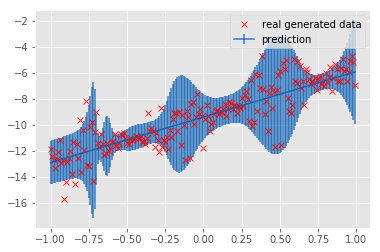

In [14]:
X_test = np.arange(low,high,0.01).reshape(-1,1)
y_test = f(X_test) + np.random.normal(
    0,std,size=(X_test.shape[0])).reshape(-1,1)+[
    np.random.normal(0,i) for i in (np.sin(X_test*-10))+1]

prediction = model.predict(X_test)

plt.errorbar(X_test,prediction[:,0],
             yerr=2*prediction[:,1],
             color='#0A5FB4',
             alpha=0.8,
             label='prediction')

plt.plot(X_test, y_test,'x',c='r',
         alpha=0.8, label='real generated data')

plt.legend()

plt.show()

## Dealing with the Epistemic uncertainty

Inside the *uncertainty quantification* field there is an approach that classifies uncertainty in two different categories:

1. Aleatoric Uncertainty: If there exists a variability in our possible correct predictions for the same initial inputs (see previous section).

2. Epistemic Uncertainty: related to our ignorance:

     2.1. We are not using the correct model ϕw to approximate the hyphothetical function f
     
     2.2. Our incomplete knowledge of the types of data that exists.

There are different techniques in the literature for modeling the epistemic uncertainty. Here, we will cover the MCMC approach using tensorflow and the tensorflow_probability library

**Problem**. Consider a data set $\{(\mathbf{x}_n, y_n)\}$, where each data point comprises of features $\mathbf{x}_n\in\mathbb{R}^D$ and output $y_n\in\mathbb{R}$. Define the likelihood for each data point as $$\begin{aligned} p(y_n \mid \mathbf{w}, \mathbf{x}_n, \sigma^2) &= \text{Normal}(y_n \mid \mathrm{NN}(\mathbf{x}_n\;;\;\mathbf{w}), \sigma^2),\end{aligned}$$

where $\mathrm{NN}$ is a neural network whose weights and biases form the latent variables $\mathbf{w}$. Assume $\sigma^2$ is a known variance.

Define the prior on the weights and biases $\mathbf{w}$ to be the standard normal $$\begin{aligned} p(\mathbf{w}) &= \text{Normal}(\mathbf{w} \mid \mathbf{0}, \mathbf{I}).\end{aligned}$$

The question here is: how these parameters (now random variables) are distributed (~posterior distribution)? Could you give an estimation of these variables?


#### Solving the inference problem using MCMC

As we noted in the introduction of this notebook, for most practical problems of interest exact inference is hard or can not be performed analytically. That is why some form of approximation need to be done. 

In this section we consider approximate inference methods based of numerical sampling to get the distribution of the latent variables.
The main idea behing MCMC is to generate samples from the posterior distribution by constructing a reversible Markov-chain that has as its equilibrium distribution the target posterior distribution. In essence, MCMC will allow us finding the expectation of some function with repect to a probability distribution -- for instance, mean and variance of the latent variables.


Ex. Using the Hamiltonian Monte Carlo `tfp.mcmc.HamiltonianMonteCarlo` method estimate the weights and biases of a linear regression problem.

Use as data:

In [15]:
def build_toy_dataset(N, w, noise_std=0.1):
    x = np.random.randn(N)
    y = x * w + np.random.normal(0, noise_std, size=N)
    return x, y

N = 40  # number of data points
D = 1  # number of features

w_true = np.random.randn()
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

Define the linear model:

In [16]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed

#tf.reset_default_graph()

def linear_model(x_data=X_train):
    A = ed.Normal(loc=0., scale=10., name="A")  
    b = ed.Normal(loc=0., scale=10., name="b")  
    mu = A * x_data + b
    y_data = ed.Normal(loc=mu, scale=tf.ones(N), name="y_data")  # `y` above
    return y_data


Compute the log-joint probability function using `ed.make_log_joint_fn`, and implements MCMC with the `tfp.mcmc.sample_chain` method:

In [17]:
log_joint = ed.make_log_joint_fn(linear_model)


def target_log_prob_fn(A, b):
    return log_joint(
      x_data=X_train,
      A=A,
      b=b,
      y_data=y_train)


num_results = 5000
num_burnin_steps = 3000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.zeros([], name='init_A'),
        tf.zeros([], name='init_b'),
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.008,
        num_leapfrog_steps=5))

A, b = states

A Coefficient:  0.88024026 +- 0.031151734 
b Coefficient:  0.00092236785 +- 0.026711533


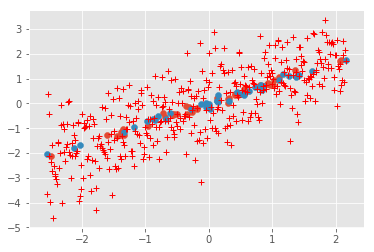

In [18]:
sess = tf.Session()

[A_mcmc, b_mcmc] = sess.run([A, b])

print("A Coefficient: ", A_mcmc.mean(), '+-', A_mcmc.var()  
      , "\nb Coefficient: ", b_mcmc.mean(), '+-', b_mcmc.var() )

def visualise(X_train, y_train, X_test, y_test, w, b, n_samples=10):
    plt.scatter(X_train, y_train)
    plt.scatter(X_test, y_test)
    inputs = np.linspace(min(X_train.min(), X_test.min()),
                         max(X_train.max(), X_test.max()), 
                         num=400)
    for ns in range(n_samples):
        #output = inputs * w[ns] + b[ns]
        output = inputs * w.mean() + b.mean()
        plt.plot(inputs, np.random.normal(output), 'r+')
        
visualise(X_train, y_train, X_test, y_test, A_mcmc, b_mcmc, n_samples=1)

#### Variational Inference

Another approach for solving the inference problem at hand is the Variational inference one. In this approach, the density function is estimated by choosing a distribution we know (eg. Gaussian) and progressively changing its parameters via optimization until it looks like the one we want to compute, the posterior. 
This “made-up” distribution we are optimizing is called variational distribution. 

Ex. Derive mathematically the equivalence between choosing the optimal parameters for the variational distribution and maximizing a lower bound

#### Dropout 

Dropout (Hinton et al) is a technique used to avoid over-fitting in our model. In essence, dropout technique zeros out neurons randomly according to a Bernoulli distribution. 

In the context of Bayesian Deep Learning, dropout can be seen as a Gaussian process approximation. In order to get uncertainty estimates from dropout, we just have to apply it both when performing training and prediction steps.

Predictive mean and variance can be obtained from the following equations:

$$ \mathbb{E}(y) \sim \frac{1}{T} \sum_{t=0}^{t=T} \hat{y}_t (x)$$

$$ Var(y) \sim \tau^{-1} \mathbb{I}_D + \frac{1}{T} \sum_{t=0}^{t=T} \hat{y}_t (x)^T \hat{y}_t (x) - \mathbb{E}(y)^T\mathbb{E}(y)$$

where $\hat{y}_t$ are the predictions and 

$$\tau = \frac{l^2 p}{2N\lambda}$$

summarizes our Gaussian process precision, with $l$ a prior length-scale that captures our belief over the function frequency, $p$ the probability of the units not being dropped, $N$ the number of points and $\lambda$ the weight decay parameter.

Let's see how to apply all these concepts taken our cosine regression problem (seen in the first classes of the course) as an example:

Ex: Implement $\tau$ parameter:

In [19]:
def tau(l, p, N, weight_decay):
    return l**2 * (1 - p) / (2 * N * weight_decay)

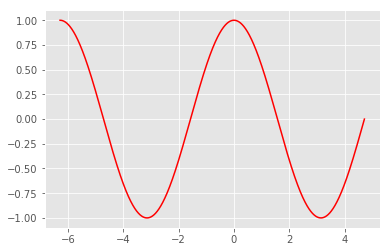

In [20]:
import numpy as np
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

f = lambda x: np.cos(x)
x_train = np.linspace(-2*np.pi, 1.5*np.pi,10000)
y_train = f(x_train)

x_test = np.linspace(1.505*np.pi,2.5*np.pi,50)
y_test = f(x_test)

x_train_norm = (x_train-x_train.mean())/(x_train.std())
y_train_norm = (y_train-y_train.mean())/(y_train.std())

plt.plot(x_train, y_train, 'r')

In [21]:
i = Input(name="input", shape=(1,), dtype='float32')
l = layers.Dense(32, input_shape=(1,), activation='relu')(i)
l = layers.BatchNormalization()(l)
l = layers.Dropout(0.3)(l, training=True)
l = layers.Dense(32, activation='relu')(l)
l = layers.BatchNormalization()(l)
l = layers.Dropout(0.3)(l, training=True)
l = layers.Dense(32, activation='relu')(l)
l = layers.BatchNormalization()(l)
l = layers.Dropout(0.7)(l, training=True)
out = layers.Dense(1, activation='tanh')(l)

m = Model(inputs=[i], outputs=out)

m.compile(optimizer=optimizers.rmsprop(), loss=losses.mean_squared_error)

h = m.fit(x_train_norm, y_train_norm, batch_size=128, epochs=10, validation_split=.2)


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 3s 369us/step - loss: 1.1651 - val_loss: 2.0022
Epoch 2/10
8000/8000 [==============================] - 1s 65us/step - loss: 0.7168 - val_loss: 1.5652
Epoch 3/10
8000/8000 [==============================] - 1s 66us/step - loss: 0.4903 - val_loss: 0.9719
Epoch 4/10
8000/8000 [==============================] - 1s 67us/step - loss: 0.3627 - val_loss: 0.6759
Epoch 5/10
8000/8000 [==============================] - 0s 60us/step - loss: 0.3049 - val_loss: 0.4943
Epoch 6/10
8000/8000 [==============================] - 0s 62us/step - loss: 0.2635 - val_loss: 0.3906
Epoch 7/10
8000/8000 [==============================] - 0s 60us/step - loss: 0.2302 - val_loss: 0.3235
Epoch 8/10
8000/8000 [==============================] - 1s 66us/step - loss: 0.2179 - val_loss: 0.3039
Epoch 9/10
8000/8000 [==============================] - 1s 64us/step - loss: 0.2044 - val_loss: 0.3018
Epoch 10/10
8000/8000 [=

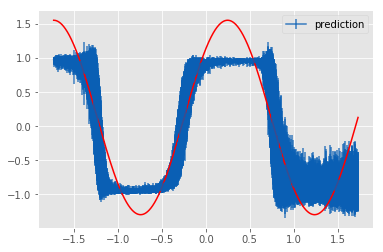

In [22]:
probs = []
for _ in range(100):
    probs += [m.predict(x_train_norm)]
predictive_mean = np.mean(probs, axis=0)
predictive_variance = np.var(probs, axis=0)
#t = tau(l, p, N, weight_decay)
#predictive_variance += tau**-1
plt.plot(x_train_norm, y_train_norm, 'r')

plt.errorbar(x_train_norm, predictive_mean,
             yerr=2*predictive_variance,
             color='#0A5FB4',
             alpha=0.8,
             label='prediction')


plt.legend()

plt.show()

Run the session, get the mean values of the weight and the bias and visualize the results:

## References

https://medium.com/@joeDiHare/deep-bayesian-neural-networks-952763a9537

http://pyro.ai/examples/bayesian_regression.html

http://edwardlib.org/tutorials/supervised-regression

https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

https://medium.com/tensorflow/introducing-tensorflow-probability-dca4c304e245

https://github.com/arturzeitler/Bayes-and-MC/blob/master/Bayesian_NN_Example.ipynb

https://arxiv.org/pdf/1610.09787.pdf